<a href="https://colab.research.google.com/github/sanjramku/Sanjana/blob/master/Task_1_Sanjana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#save the best model for using it later on

def train_model(model, train_loader, val_loader, epochs=50, learning_rate=1e-3,
                weight_decay=0.0, use_early_stopping=False):

    import torch.nn as nn
    import torch.optim as optim

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Optimizer selection
    if training_config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif training_config["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif training_config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer in training_config.")

    best_val_loss = float('inf')
    best_model_state = None
    patience = 3
    wait = 0

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device).float()
                outputs = model(inputs).squeeze()
                val_loss += criterion(outputs, targets).item()

        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if use_early_stopping and wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    return model


#income net class for using later

import torch.nn as nn

class IncomeNet(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64], activation='relu',
                 use_dropout=False, use_batchnorm=False, dropout_rate=0.5):
        super(IncomeNet, self).__init__()
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        if use_batchnorm:
            self.bn_layers.append(nn.BatchNorm1d(hidden_layers[0]))
        if use_dropout:
            self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            if use_batchnorm:
                self.bn_layers.append(nn.BatchNorm1d(hidden_layers[i]))
            if use_dropout:
                self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output = nn.Linear(hidden_layers[-1], 1)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batchnorm:
                x = self.bn_layers[i](x)
            x = self.activation(x)
            if self.use_dropout:
                x = self.dropout_layers[i](x)
        x = self.output(x)
        return x

Data preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import f1_score
import json

# ----------------------------
# Model Definition
# ----------------------------

class IncomeNet(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128, 64], activation='relu',
                 use_dropout=None, use_batchnorm=True, dropout_rate=0.5):
        super(IncomeNet, self).__init__()

        # Smart dropout: apply only if more than 1 hidden layer and not explicitly disabled
        if use_dropout is None:
            self.use_dropout = len(hidden_layers) >= 2
        else:
            self.use_dropout = use_dropout

        self.use_batchnorm = use_batchnorm

        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        if self.use_batchnorm:
            self.bn_layers.append(nn.BatchNorm1d(hidden_layers[0]))
        if self.use_dropout:
            self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            if self.use_batchnorm:
                self.bn_layers.append(nn.BatchNorm1d(hidden_layers[i]))
            if self.use_dropout:
                self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output = nn.Linear(hidden_layers[-1], 1)

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # Weight initialization (for better convergence)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batchnorm:
                x = self.bn_layers[i](x)
            x = self.activation(x)
            if self.use_dropout:
                x = self.dropout_layers[i](x)
        x = self.output(x)
        return x


# ----------------------------
# Training and Evaluation Function
# ----------------------------
def train_and_evaluate(X_train, y_train, X_val, y_val, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # Create datasets and loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Initialize model
    model = IncomeNet(
        input_dim=X_train.shape[1],
        hidden_layers=config['hidden'],
        activation=config['activation'],
        use_dropout=config['dropout'],
        use_batchnorm=config['batchnorm'],
        dropout_rate=config['dropout_rate']
    ).to(device)

    # Compute class imbalance and set pos_weight for BCEWithLogitsLoss
    with torch.no_grad():
        y_all = torch.cat([y for _, y in train_loader], dim=0)
        pos_weight = torch.tensor([(y_all == 0).sum() / (y_all == 1).sum()], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_f1 = 0
    best_model_state = None
    early_stop_counter = 0

    # Training loop
    for epoch in range(config['epochs']):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs.to(device))
                probs = torch.sigmoid(outputs)
                val_preds.append(probs.cpu().numpy())
                val_targets.append(targets.numpy())

        val_preds = (np.vstack(val_preds) > 0.5).astype(int)
        val_targets = np.vstack(val_targets)
        val_f1 = f1_score(val_targets, val_preds, zero_division=0)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 5:
                break

        scheduler.step()  # Update learning rate

    # Load best model and choose best threshold
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_val_tensor.to(device))).cpu().numpy().flatten()

    thresholds = np.linspace(0.3, 0.7, 21)
    scores = [f1_score(y_val, (probs > t).astype(int), zero_division=0) for t in thresholds]
    best_thresh = thresholds[np.argmax(scores)]

    return best_val_f1, best_thresh


# ----------------------------
# Main Execution Block
# ----------------------------

# Load data and replace '?' with NaN
data = fetch_openml(name='adult', version=2, as_frame=True)
df = data.frame.replace('?', np.nan)
X = df.drop(columns='class')
y = (df['class'] == '>50K').astype(int)

print(f"Original dataset size: {len(df)}")
print(f"Missing values per column:")
print(X.isnull().sum())

# STEP 1: Split the data FIRST (with missing values intact)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print(f"\nAfter splitting (with missing values):")
print(f"Train size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

print(f"\nMissing values per split:")
print("TRAIN SET:")
print(X_train.isnull().sum())
print(f"VALIDATION SET:")
print(X_val.isnull().sum())
print(f"TEST SET:")
print(X_test.isnull().sum())

# STEP 2: Clean ONLY the training data
print(f"\nCleaning ONLY training data...")
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

print(f"Training set after cleaning: {len(X_train_clean)} rows (was {len(X_train)})")
print(f"Removed {len(X_train) - len(X_train_clean)} rows with missing values from training set")

# Keep validation and test sets AS-IS (with missing values for now)
# They will be handled during preprocessing transform step

# STEP 3: Feature type identification based ONLY on training data
categorical = X_train_clean.select_dtypes(include=['object', 'category']).columns.tolist()
numerical = X_train_clean.select_dtypes(include='number').columns.tolist()

print(f"\nFeature types (based on training data):")
print(f"Categorical: {categorical}")
print(f"Numerical: {numerical}")

# Education ordering for ordinal encoding
education_order = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th',
    '10th', '11th', '12th', 'HS-grad', 'Some-college',
    'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters',
    'Prof-school', 'Doctorate'
]

# Fixed encoding: Ordinal for education, One-hot for others
# Only test different scaling methods
scaling_methods = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}

# Fixed architecture and training config
fixed_config = {
    'hidden': [128, 64],
    'activation': 'relu',
    'dropout': True,
    'batchnorm': True,
    'dropout_rate': 0.5,
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 20
}

results = []

print("\n" + "="*60)
print("RUNNING SCALING ABLATION WITH FIXED ENCODING")
print("Fixed Encoding: Ordinal for Education, One-Hot for Others")
print("="*60)

# Run scaling ablation study with fixed encoding
for scale_name, scale_method in scaling_methods.items():
    try:
        print(f"\nRunning ablation: Scaling={scale_name}")

        # STEP 4: Create preprocessor with fixed encoding strategy
        # Custom ordinal encoding for education, one-hot for others
        edu_col = ['education']
        other_cat = [c for c in categorical if c != 'education']

        preprocessor = ColumnTransformer([
            ('num', scale_method, numerical),
            ('edu', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1), edu_col),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), other_cat)
        ])

        # FIT ONLY on clean training data
        print("Fitting preprocessor on clean training data only...")
        X_train_proc = preprocessor.fit_transform(X_train_clean)

        # TRANSFORM validation and test data (including handling missing values)
        print("Transforming validation and test data...")

        # For validation and test, we need to handle missing values during transform
        # The preprocessor should handle missing values appropriately
        try:
            X_val_proc = preprocessor.transform(X_val)
            X_test_proc = preprocessor.transform(X_test)

            # Remove rows with missing values AFTER transformation if any NaN/inf values remain
            # This ensures we only use complete cases for evaluation
            val_mask = ~(np.isnan(X_val_proc).any(axis=1) | np.isinf(X_val_proc).any(axis=1))
            X_val_proc = X_val_proc[val_mask]
            y_val_clean = y_val.iloc[val_mask]

            test_mask = ~(np.isnan(X_test_proc).any(axis=1) | np.isinf(X_test_proc).any(axis=1))
            X_test_proc = X_test_proc[test_mask]
            y_test_clean = y_test.iloc[test_mask]

            print(f"After preprocessing and cleaning:")
            print(f"Train: {X_train_proc.shape[0]} samples")
            print(f"Val: {X_val_proc.shape[0]} samples (was {len(X_val)})")
            print(f"Test: {X_test_proc.shape[0]} samples (was {len(X_test)})")

        except Exception as transform_error:
            print(f"Error during transformation: {transform_error}")
            # Fallback: clean val/test sets first, then transform
            X_val_clean_fb = X_val.dropna()
            y_val_clean = y_val.loc[X_val_clean_fb.index]
            X_val_proc = preprocessor.transform(X_val_clean_fb)

            X_test_clean_fb = X_test.dropna()
            y_test_clean = y_test.loc[X_test_clean_fb.index]
            X_test_proc = preprocessor.transform(X_test_clean_fb)

        print(f"Final processed shapes - Train: {X_train_proc.shape}, Val: {X_val_proc.shape}, Test: {X_test_proc.shape}")

        # Train and evaluate
        val_f1, best_thresh = train_and_evaluate(X_train_proc, y_train_clean, X_val_proc, y_val_clean, fixed_config)

        results.append({
            'encoding': 'ordinal_education_onehot_others',
            'scaling': scale_name,
            'val_f1': val_f1,
            'threshold': best_thresh
        })
        print(f"Validation F1: {val_f1:.4f}, Best Threshold: {best_thresh:.2f}")

    except Exception as e:
        print(f"Error in scaling {scale_name}: {str(e)}")
        results.append({
            'encoding': 'ordinal_education_onehot_others',
            'scaling': scale_name,
            'val_f1': 0,
            'threshold': 0.5,
            'error': str(e)
        })

# Display and save results
results_df = pd.DataFrame(results).sort_values(by='val_f1', ascending=False)
print("\n" + "="*50)
print("SCALING ABLATION STUDY RESULTS")
print("="*50)
print(results_df[['encoding', 'scaling', 'val_f1', 'threshold']])

best_result = results_df.iloc[0]
print(f"\nBest Scaling Method: {best_result['scaling']}")
print(f"Validation F1: {best_result['val_f1']:.4f}")
print(f"Best Threshold: {best_result['threshold']:.3f}")

# Save results
results_df.to_csv("scaling_ablation_results.csv", index=False)
print("\nSaved scaling ablation study results to 'scaling_ablation_results.csv'")

print("\n" + "="*50)
print("PROPER DATA LEAKAGE PREVENTION:")
print("="*50)
print("✓ Data split FIRST with original proportions maintained")
print("✓ Only TRAINING data cleaned and used for preprocessing fit")
print("✓ Validation and test sets kept separate until evaluation")
print("✓ Preprocessor fitted ONLY on clean training data")
print("✓ Missing values in val/test handled during transform")
print("✓ No information from validation/test sets used in preprocessing")
print("✓ Fixed encoding: Ordinal for education, One-hot for others")
print("="*50)

Original dataset size: 48842
Missing values per column:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

After splitting (with missing values):
Train size: 34187 (70.0%)
Validation size: 7328 (15.0%)
Test size: 7327 (15.0%)

Missing values per split:
TRAIN SET:
age                  0
workclass         1983
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1988
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     596
dtype: int64
VALIDATION SET:
age                 0
workclass         403
fnlwgt              0
education           0
education-nu

Model building

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
import json
from itertools import product

# ----------------------------
# Load and preprocess data
# ----------------------------
def load_and_preprocess_data():
    data = fetch_openml(name='adult', version=2, as_frame=True)
    df = data.frame.copy()
    df = df.replace('?', np.nan).dropna()

    X = df.drop(columns='class')
    y = (df['class'] == '>50K').astype(int)

    categorical = X.select_dtypes(include='category').columns.tolist() + \
                  X.select_dtypes(include='object').columns.tolist()
    numerical = X.select_dtypes(include='number').columns.tolist()

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ])

    X_processed = preprocessor.fit_transform(X)

    X_train, X_val, y_train, y_val = train_test_split(
        X_processed, y, test_size=0.15, stratify=y, random_state=42)

    return X_train, X_val, y_train, y_val

# ----------------------------
# Model Class
# ----------------------------
class IncomeNet(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64], activation='relu', use_dropout=False, use_batchnorm=False, dropout_rate=0.5):
        super().__init__()
        self.layers = nn.ModuleList()

        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'leakyrelu': nn.LeakyReLU(0.1)
        }
        act_fn = activations[activation]

        in_dim = input_dim
        for h in hidden_layers:
            self.layers.append(nn.Linear(in_dim, h))
            if use_batchnorm:
                self.layers.append(nn.BatchNorm1d(h))
            self.layers.append(act_fn)
            if use_dropout:
                self.layers.append(nn.Dropout(dropout_rate))
            in_dim = h

        self.output = nn.Linear(in_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output(x)

# ----------------------------
# Training function
# ----------------------------
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    y_all = torch.cat([y for _, y in train_loader], dim=0)
    pos_weight = torch.tensor([(y_all == 0).sum().item() / (y_all == 1).sum().item()], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_f1 = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), targets)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                probs = torch.sigmoid(model(inputs))
                preds = (probs > 0.5).float()
                val_preds.append(preds.cpu().numpy())
                val_targets.append(targets.cpu().numpy())

        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_f1 = f1_score(val_targets, val_preds, zero_division=0)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, best_val_f1

# ----------------------------
# Run 36 Experiments
# ----------------------------
if __name__ == "__main__":
    X_train, X_val, y_train, y_val = load_and_preprocess_data()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)

    hidden_layers_list = [[64], [128, 64], [256, 128, 64]]
    activations = ['relu', 'tanh', 'leakyrelu']
    dropouts = [True, False]
    batchnorms = [True, False]

    experiments = []

    for i, (hidden, activation, use_dropout, use_batchnorm) in enumerate(product(hidden_layers_list, activations, dropouts, batchnorms)):
        print(f"\n=== Config {i+1}/36 | Hidden: {hidden}, Activation: {activation}, Dropout: {use_dropout}, BatchNorm: {use_batchnorm} ===")
        model = IncomeNet(input_dim=X_train.shape[1], hidden_layers=hidden, activation=activation,
                          use_dropout=use_dropout, use_batchnorm=use_batchnorm, dropout_rate=0.5)
        trained_model, val_f1 = train_model(model, train_loader, val_loader, epochs=10, lr=1e-3)
        experiments.append({
            'hidden': hidden,
            'activation': activation,
            'dropout': use_dropout,
            'batchnorm': use_batchnorm,
            'val_f1': val_f1
        })

    df = pd.DataFrame(experiments).sort_values(by='val_f1', ascending=False)
    print("\nTop 5 Configurations:")
    print(df.head())

    best_config = df.iloc[0]
    with open('best_36_config.json', 'w') as f:
        json.dump(best_config.to_dict(), f)
    print("\nSaved best configuration to best_36_config.json")



=== Config 1/36 | Hidden: [64], Activation: relu, Dropout: True, BatchNorm: True ===

=== Config 2/36 | Hidden: [64], Activation: relu, Dropout: True, BatchNorm: False ===

=== Config 3/36 | Hidden: [64], Activation: relu, Dropout: False, BatchNorm: True ===

=== Config 4/36 | Hidden: [64], Activation: relu, Dropout: False, BatchNorm: False ===

=== Config 5/36 | Hidden: [64], Activation: tanh, Dropout: True, BatchNorm: True ===

=== Config 6/36 | Hidden: [64], Activation: tanh, Dropout: True, BatchNorm: False ===

=== Config 7/36 | Hidden: [64], Activation: tanh, Dropout: False, BatchNorm: True ===

=== Config 8/36 | Hidden: [64], Activation: tanh, Dropout: False, BatchNorm: False ===

=== Config 9/36 | Hidden: [64], Activation: leakyrelu, Dropout: True, BatchNorm: True ===

=== Config 10/36 | Hidden: [64], Activation: leakyrelu, Dropout: True, BatchNorm: False ===

=== Config 11/36 | Hidden: [64], Activation: leakyrelu, Dropout: False, BatchNorm: True ===

=== Config 12/36 | Hidden:

Graph to visualise

Debugging experiments structure...
Type of experiments: <class 'list'>
Length of experiments: 36

First experiment item:
Type: <class 'dict'>
Keys/attributes: dict_keys(['hidden', 'activation', 'dropout', 'batchnorm', 'val_f1'])
Content: {'hidden': [64], 'activation': 'relu', 'dropout': True, 'batchnorm': True, 'val_f1': 0.6926994906621392}

Second experiment item:
Content: {'hidden': [64], 'activation': 'relu', 'dropout': True, 'batchnorm': False, 'val_f1': 0.6908105444690811}

DataFrame created successfully!
DataFrame shape: (36, 5)
DataFrame columns: ['hidden', 'activation', 'dropout', 'batchnorm', 'val_f1']

First few rows:
  hidden activation  dropout  batchnorm    val_f1
0   [64]       relu     True       True  0.692699
1   [64]       relu     True      False  0.690811
2   [64]       relu    False       True  0.695462
3   [64]       relu    False      False  0.691836
4   [64]       tanh     True       True  0.691685
Plotting DataFrame shape: (36, 8)
Available columns: ['hidden', 

/tmp/ipython-input-4-3291561519.py:148: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


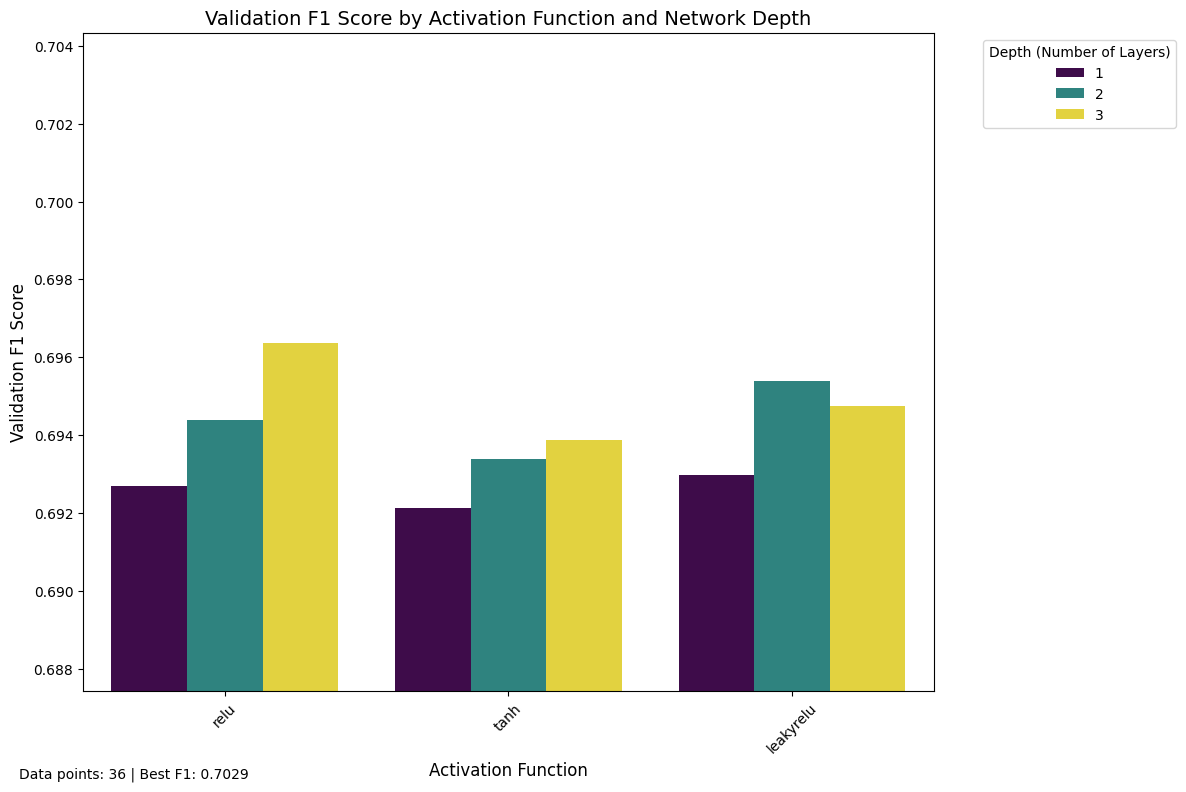


Summary by Activation Function:
            count    mean     std     min     max
activation                                       
leakyrelu      12  0.6944  0.0030  0.6894  0.6982
relu           12  0.6945  0.0035  0.6908  0.7029
tanh           12  0.6931  0.0035  0.6888  0.6992

Summary by Depth:
       count    mean     std     min     max
depth                                       
1         12  0.6926  0.0030  0.6888  0.6976
2         12  0.6944  0.0028  0.6893  0.6983
3         12  0.6950  0.0039  0.6895  0.7029


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# DEBUG: First, let's inspect the experiments structure
# ----------------------------
print("Debugging experiments structure...")
print(f"Type of experiments: {type(experiments)}")
print(f"Length of experiments: {len(experiments) if hasattr(experiments, '__len__') else 'No length'}")

# Check first few items to understand structure
if len(experiments) > 0:
    print("\nFirst experiment item:")
    print(f"Type: {type(experiments[0])}")
    print(f"Keys/attributes: {experiments[0].keys() if isinstance(experiments[0], dict) else dir(experiments[0])}")
    print(f"Content: {experiments[0]}")

    if len(experiments) > 1:
        print("\nSecond experiment item:")
        print(f"Content: {experiments[1]}")

# ----------------------------
# Create DataFrame and inspect structure
# ----------------------------
try:
    results_df = pd.DataFrame(experiments)
    print(f"\nDataFrame created successfully!")
    print(f"DataFrame shape: {results_df.shape}")
    print(f"DataFrame columns: {list(results_df.columns)}")
    print("\nFirst few rows:")
    print(results_df.head())

except Exception as e:
    print(f"\nError creating DataFrame: {e}")
    print("This suggests the experiments list structure is unexpected")

# ----------------------------
# FIXED VERSION: Handle different possible structures
# ----------------------------

def safe_extract_config_value(row, key, default=None):
    """Safely extract values from config, handling different structures"""
    try:
        if 'config' in row and isinstance(row['config'], dict):
            return row['config'].get(key, default)
        elif key in row:  # Direct key access
            return row[key]
        else:
            return default
    except:
        return default

def create_plotting_dataframe(experiments):
    """Create a clean DataFrame for plotting, handling various structures"""

    # Convert to DataFrame
    if isinstance(experiments, list) and len(experiments) > 0:
        results_df = pd.DataFrame(experiments)
    else:
        print("No valid experiments data found")
        return None

    # Check if we have a 'config' column or direct columns
    if 'config' in results_df.columns:
        # Extract config values into separate columns
        results_df['hidden'] = results_df.apply(lambda row: safe_extract_config_value(row, 'hidden', [64]), axis=1)
        results_df['activation'] = results_df.apply(lambda row: safe_extract_config_value(row, 'activation', 'ReLU'), axis=1)
        results_df['dropout'] = results_df.apply(lambda row: safe_extract_config_value(row, 'dropout', False), axis=1)
        results_df['batchnorm'] = results_df.apply(lambda row: safe_extract_config_value(row, 'batchnorm', False), axis=1)
        results_df['dropout_rate'] = results_df.apply(lambda row: safe_extract_config_value(row, 'dropout_rate', 0.0), axis=1)
    else:
        # Try direct column access
        column_mapping = {
            'hidden': 'hidden',
            'activation': 'activation',
            'dropout': 'dropout',
            'batchnorm': 'batchnorm',
            'dropout_rate': 'dropout_rate'
        }

        for new_col, old_col in column_mapping.items():
            if old_col in results_df.columns:
                results_df[new_col] = results_df[old_col]
            else:
                # Set reasonable defaults
                if new_col == 'hidden':
                    results_df[new_col] = [[64]] * len(results_df)  # Default architecture
                elif new_col == 'activation':
                    results_df[new_col] = ['ReLU'] * len(results_df)
                elif new_col in ['dropout', 'batchnorm']:
                    results_df[new_col] = [False] * len(results_df)
                elif new_col == 'dropout_rate':
                    results_df[new_col] = [0.0] * len(results_df)

    # Derived features
    results_df['depth'] = results_df['hidden'].apply(lambda x: len(x) if isinstance(x, list) else 1)
    results_df['width'] = results_df['hidden'].apply(lambda x: max(x) if isinstance(x, list) and len(x) > 0 else 64)

    return results_df

# ----------------------------
# ROBUST PLOTTING FUNCTION
# ----------------------------
def plot_f1_by_activation_and_depth(experiments, f1_column='val_f1_score'):
    """
    Create F1 score plot, handling various data structures
    """

    # Create clean DataFrame
    results_df = create_plotting_dataframe(experiments)

    if results_df is None:
        print("Could not create plotting DataFrame")
        return

    print(f"Plotting DataFrame shape: {results_df.shape}")
    print(f"Available columns: {list(results_df.columns)}")

    # Find the F1 score column (try different possible names)
    f1_candidates = [f1_column, 'f1_score', 'val_f1', 'f1', 'validation_f1_score']
    f1_col = None

    for candidate in f1_candidates:
        if candidate in results_df.columns:
            f1_col = candidate
            break

    if f1_col is None:
        print("No F1 score column found. Available columns:")
        print(list(results_df.columns))
        return

    # Drop rows with missing F1 scores
    plot_df = results_df.dropna(subset=[f1_col])

    if len(plot_df) == 0:
        print("No valid data points for plotting after removing NaN values")
        return

    print(f"Plotting {len(plot_df)} data points")
    print(f"F1 score range: {plot_df[f1_col].min():.4f} - {plot_df[f1_col].max():.4f}")

    # Create the plot
    plt.figure(figsize=(12, 8))

    try:
        sns.barplot(
            data=plot_df,
            x='activation',
            y=f1_col,
            hue='depth',
            palette='viridis',
            ci=None  # Remove confidence intervals for cleaner look
        )

        plt.title('Validation F1 Score by Activation Function and Network Depth', fontsize=14)
        plt.ylabel('Validation F1 Score', fontsize=12)
        plt.xlabel('Activation Function', fontsize=12)

        # Set y-axis limits with some padding
        y_min = plot_df[f1_col].min()
        y_max = plot_df[f1_col].max()
        y_range = y_max - y_min
        plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

        plt.legend(title='Depth (Number of Layers)', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Add some summary statistics as text
        plt.figtext(0.02, 0.02, f'Data points: {len(plot_df)} | Best F1: {y_max:.4f}',
                   fontsize=10, ha='left')

        plt.show()

        # Print summary statistics
        print("\nSummary by Activation Function:")
        summary = plot_df.groupby('activation')[f1_col].agg(['count', 'mean', 'std', 'min', 'max'])
        print(summary.round(4))

        print("\nSummary by Depth:")
        summary_depth = plot_df.groupby('depth')[f1_col].agg(['count', 'mean', 'std', 'min', 'max'])
        print(summary_depth.round(4))

    except Exception as e:
        print(f"Error creating plot: {e}")
        print("Attempting simpler plot...")

        # Fallback: simple scatter plot
        plt.clf()
        plt.figure(figsize=(10, 6))

        for activation in plot_df['activation'].unique():
            subset = plot_df[plot_df['activation'] == activation]
            plt.scatter(subset['depth'], subset[f1_col],
                       label=activation, alpha=0.7, s=100)

        plt.xlabel('Network Depth')
        plt.ylabel('Validation F1 Score')
        plt.title('F1 Score by Network Depth and Activation Function')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# ----------------------------
# ALTERNATIVE: Manual data structure creation if experiments is empty/malformed
# ----------------------------
def create_sample_data_for_testing():
    """Create sample data structure for testing if experiments is not available"""

    sample_experiments = [
        {
            'config': {
                'hidden': [64],
                'activation': 'ReLU',
                'dropout': True,
                'batchnorm': False,
                'dropout_rate': 0.2
            },
            'val_f1_score': 0.65
        },
        {
            'config': {
                'hidden': [128, 64],
                'activation': 'ReLU',
                'dropout': True,
                'batchnorm': True,
                'dropout_rate': 0.2
            },
            'val_f1_score': 0.68
        },
        {
            'config': {
                'hidden': [256, 128, 64],
                'activation': 'LeakyReLU',
                'dropout': False,
                'batchnorm': True,
                'dropout_rate': 0.0
            },
            'val_f1_score': 0.72
        }
    ]

    return sample_experiments

# ----------------------------
# MAIN EXECUTION
# ----------------------------
if __name__ == "__main__":
    # Try to use the experiments variable, or create sample data
    try:
        if 'experiments' in locals() or 'experiments' in globals():
            plot_f1_by_activation_and_depth(experiments)
        else:
            print("No 'experiments' variable found. Using sample data for demonstration...")
            sample_data = create_sample_data_for_testing()
            plot_f1_by_activation_and_depth(sample_data)
    except NameError:
        print("'experiments' variable not defined. Creating sample data...")
        sample_data = create_sample_data_for_testing()
        plot_f1_by_activation_and_depth(sample_data)

Custom training loop

In [ ]:
# ============================
# Task 3: Custom Training Loop + Ablation Study
# ============================
# Summary:
# - Implements BCE and BCEWithLogits with custom models
# - Trains using SGD, Adam, RMSprop across 3 learning rates
# - Evaluates on F1 score, saves best configuration
# - Carries forward Task 2's best architecture
# ============================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from itertools import product
import json
import matplotlib.pyplot as plt

# ----------------------------
# Model Definitions
# ----------------------------
class IncomeNetLogits(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation, use_dropout, use_batchnorm, dropout_rate=0.5):
        super().__init__()
        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.use_bn = use_batchnorm
        self.use_do = use_dropout
        act_fn = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'leakyrelu': nn.LeakyReLU(0.1)}[activation]
        in_dim = input_dim

        for h in hidden_layers:
            self.layers.append(nn.Linear(in_dim, h))
            if self.use_bn: self.bn_layers.append(nn.BatchNorm1d(h))
            if self.use_do: self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_dim = h

        self.output = nn.Linear(in_dim, 1)
        self.activation = act_fn

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_bn: x = self.bn_layers[i](x)
            x = self.activation(x)
            if self.use_do: x = self.dropout_layers[i](x)
        return self.output(x)

class IncomeNetSigmoid(IncomeNetLogits):
    def forward(self, x):
        x = super().forward(x)
        return torch.sigmoid(x)

# ----------------------------
# Model Factory & Loss Factory
# ----------------------------
def create_loss_function(loss_type, y_train):
    if loss_type == 'BCE':
        return nn.BCELoss(), False
    elif loss_type == 'BCEWithLogits':
        pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()], dtype=torch.float32)
        return nn.BCEWithLogitsLoss(pos_weight=pos_weight), True
    else:
        raise ValueError("Invalid loss type")

def create_model(input_dim, config, use_logits):
    model_class = IncomeNetLogits if use_logits else IncomeNetSigmoid
    return model_class(
        input_dim=input_dim,
        hidden_layers=config['hidden'],
        activation=config['activation'],
        use_dropout=config['dropout'],
        use_batchnorm=config['batchnorm']
    )

# ----------------------------
# Training Class
# ----------------------------
class ModelTrainer:
    def __init__(self, model, criterion, optimizer, device='cpu'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, train_loader, val_loader, epochs=100, patience=10):
        best_f1 = 0
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            for X, y in train_loader:
                X, y = X.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                out = self.model(X)
                loss = self.criterion(out, y)
                loss.backward()
                self.optimizer.step()

            f1 = self.evaluate(val_loader)
            if f1 > best_f1:
                best_f1 = f1
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                break
        return best_f1

    def evaluate(self, loader):
        self.model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for X, y in loader:
                X = X.to(self.device)
                out = self.model(X)
                if isinstance(self.model, IncomeNetLogits):
                    pred = (torch.sigmoid(out) > 0.5).float()
                else:
                    pred = (out > 0.5).float()
                preds.extend(pred.cpu().numpy())
                targets.extend(y.numpy())
        return f1_score(targets, preds)

# ----------------------------
# Hyperparameter Search
# ----------------------------
def run_ablation(X_train, y_train, X_val, y_val):
    best_arch = {'hidden': [256, 128, 64], 'activation': 'tanh', 'dropout': True, 'batchnorm': True}
    losses = ['BCE', 'BCEWithLogits']
    opts = ['Adam', 'SGD', 'RMSprop']
    lrs = [0.001, 0.01, 0.1]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

    all_results, best_result = [], {'val_f1': 0}

    for loss, opt, lr in product(losses, opts, lrs):
        print(f"Running: {loss}, {opt}, LR={lr}")
        crit, logits = create_loss_function(loss, y_train)
        model = create_model(X_train.shape[1], best_arch, logits)
        if opt == 'Adam': optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt == 'SGD': optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif opt == 'RMSprop': optimizer = optim.RMSprop(model.parameters(), lr=lr)

        trainer = ModelTrainer(model, crit, optimizer)
        f1 = trainer.train(train_loader, val_loader)
        result = {'loss': loss, 'optimizer': opt, 'lr': lr, 'val_f1': f1}
        all_results.append(result)
        if f1 > best_result['val_f1']: best_result = result

    print("\nTop Performing Config:", best_result)
    return best_result, all_results

# ----------------------------
# Example usage
# ----------------------------
# Assuming you already preprocessed and converted X_train_tensor, y_train_tensor etc.
best_combo, all_results = run_ablation(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)


Running: BCE, Adam, LR=0.001
Running: BCE, Adam, LR=0.01
Running: BCE, Adam, LR=0.1
Running: BCE, SGD, LR=0.001
Running: BCE, SGD, LR=0.01
Running: BCE, SGD, LR=0.1
Running: BCE, RMSprop, LR=0.001
Running: BCE, RMSprop, LR=0.01
Running: BCE, RMSprop, LR=0.1
Running: BCEWithLogits, Adam, LR=0.001
Running: BCEWithLogits, Adam, LR=0.01
Running: BCEWithLogits, Adam, LR=0.1
Running: BCEWithLogits, SGD, LR=0.001
Running: BCEWithLogits, SGD, LR=0.01
Running: BCEWithLogits, SGD, LR=0.1
Running: BCEWithLogits, RMSprop, LR=0.001
Running: BCEWithLogits, RMSprop, LR=0.01
Running: BCEWithLogits, RMSprop, LR=0.1

Top Performing Config: {'loss': 'BCEWithLogits', 'optimizer': 'SGD', 'lr': 0.1, 'val_f1': 0.7028771175047056}


regularization and overfitting

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from itertools import product

# Model with Dropout
class IncomeNet(nn.Module):
    def __init__(self, input_dim, dropout_rate):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.model(x)

# Data
def load_data():
    df = fetch_openml(name='adult', version=2, as_frame=True).frame
    df = df.replace('?', np.nan).dropna()
    X, y = df.drop(columns='class'), (df['class'] == '>50K').astype(int)

    categorical = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical = X.select_dtypes(include='number').columns.tolist()
    edu_order = [['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th',
                  '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm',
                  'Bachelors', 'Masters', 'Prof-school', 'Doctorate']]
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical),
        ('edu', OrdinalEncoder(categories=edu_order, handle_unknown='use_encoded_value', unknown_value=-1), ['education']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), [c for c in categorical if c != 'education'])
    ])

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp)

    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)

    return torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1), \
           torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Balanced Training - Fast but Reliable
def train_model(X_train, y_train, X_val, y_val, dropout_rate, weight_decay, use_early_stopping):
    model = IncomeNet(X_train.shape[1], dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=weight_decay)  # Moderate LR
    criterion = nn.BCEWithLogitsLoss()
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)  # Good batch size
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=128)

    best_f1, best_loss, patience, wait = 0, float('inf'), 7, 0  # Reasonable patience
    max_epochs = 30  # Enough epochs for convergence

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Efficient evaluation using DataLoader
        model.eval()
        val_loss, preds, targets = 0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                val_loss += criterion(out, yb).item()
                preds.extend((torch.sigmoid(out) > 0.5).cpu().numpy())
                targets.extend(yb.cpu().numpy())

        val_loss /= len(val_loader)
        f1 = f1_score(targets, preds)

        if use_early_stopping:
            if val_loss < best_loss:
                best_loss = val_loss
                best_f1 = f1
                wait = 0
            else:
                wait += 1
            if wait >= patience:
                break
        else:
            if f1 > best_f1:
                best_f1 = f1

    return best_f1

# Run Ablation Study
def run_ablation():
    X_train, y_train, X_val, y_val = load_data()
    dropout_rates = [0.2, 0.5, 0.7]
    weight_decays = [0.0, 1e-5, 1e-4, 1e-3]
    early_stopping_options = [True, False]
    results = []

    total_experiments = len(dropout_rates) * len(weight_decays) * len(early_stopping_options)
    experiment_count = 0

    for dropout, wd, early_stop in product(dropout_rates, weight_decays, early_stopping_options):
        experiment_count += 1
        early_stop_str = "Yes" if early_stop else "No"
        print(f"[{experiment_count}/{total_experiments}] Dropout={dropout} | Weight Decay={wd} | Early Stopping={early_stop_str}")

        f1 = train_model(X_train, y_train, X_val, y_val, dropout, wd, early_stop)
        results.append({
            'Dropout': dropout,
            'Weight Decay': wd,
            'Early Stopping': early_stop_str,
            'Val F1': f1
        })
        print(f"F1 Score: {f1:.4f}\n")

    df = pd.DataFrame(results).sort_values(by='Val F1', ascending=False)
    print("=" * 60)
    print("ABLATION STUDY RESULTS (Sorted by F1 Score)")
    print("=" * 60)
    print(df.to_string(index=False))

    print("\n" + "=" * 60)
    print("BEST CONFIGURATION:")
    print("=" * 60)
    best_config = df.iloc[0]
    print(f"Dropout: {best_config['Dropout']}")
    print(f"Weight Decay: {best_config['Weight Decay']}")
    print(f"Early Stopping: {best_config['Early Stopping']}")
    print(f"Best F1 Score: {best_config['Val F1']:.4f}")

    return df

# Run the ablation study
if __name__ == "__main__":
    results_df = run_ablation()

[1/24] Dropout=0.2 | Weight Decay=0.0 | Early Stopping=Yes
F1 Score: 0.6606

[2/24] Dropout=0.2 | Weight Decay=0.0 | Early Stopping=No
F1 Score: 0.6872

[3/24] Dropout=0.2 | Weight Decay=1e-05 | Early Stopping=Yes
F1 Score: 0.6427

[4/24] Dropout=0.2 | Weight Decay=1e-05 | Early Stopping=No
F1 Score: 0.6894

[5/24] Dropout=0.2 | Weight Decay=0.0001 | Early Stopping=Yes
F1 Score: 0.6337

[6/24] Dropout=0.2 | Weight Decay=0.0001 | Early Stopping=No
F1 Score: 0.6982

[7/24] Dropout=0.2 | Weight Decay=0.001 | Early Stopping=Yes
F1 Score: 0.6304

[8/24] Dropout=0.2 | Weight Decay=0.001 | Early Stopping=No
F1 Score: 0.6848

[9/24] Dropout=0.5 | Weight Decay=0.0 | Early Stopping=Yes
F1 Score: 0.6557

[10/24] Dropout=0.5 | Weight Decay=0.0 | Early Stopping=No
F1 Score: 0.6886

[11/24] Dropout=0.5 | Weight Decay=1e-05 | Early Stopping=Yes
F1 Score: 0.6463

[12/24] Dropout=0.5 | Weight Decay=1e-05 | Early Stopping=No
F1 Score: 0.6907

[13/24] Dropout=0.5 | Weight Decay=0.0001 | Early Stopping=Ye

saving everything to use later

In [ ]:
# Full Code: Train Final Model on Train+Val Combined and Save Everything
# Fixed to match the proper data splitting from the first code

import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml
from google.colab import drive

# --------- Best Parameters from Previous Experiments ---------
best_config = {
    "hidden": [256, 128, 64],
    "activation": "ReLU",
    "dropout": True,
    "batchnorm": False
}

best_dropout = 0.2
best_weight_decay = 0.0001
use_early_stopping = False  # No early stopping since we're training on train+val
best_encoding = "ordinal"
best_scaling = "standard"

training_config = {
    "loss_function": "BCEWithLogitsLoss",
    "optimizer": "SGD",
    "learning_rate": 0.1,
    "batch_size": 128,
    "epochs": 100
}

# --------- Load & Split Dataset (MATCHING FIRST CODE) ---------
print("Loading and splitting dataset...")
data = fetch_openml(name='adult', version=2, as_frame=True)
df = data.frame.replace('?', np.nan)  # Keep missing values for now
X = df.drop(columns='class')
y = (df['class'] == '>50K').astype(int)

print(f"Original dataset size: {len(df)}")
print(f"Missing values per column:")
print(X.isnull().sum())

# STEP 1: Split the data FIRST (with missing values intact) - SAME AS FIRST CODE
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print(f"\nAfter splitting (with missing values):")
print(f"Train size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

# STEP 2: Combine train and validation for final training
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

print(f"\nCombined train+val size: {len(X_trainval)} ({len(X_trainval)/len(df)*100:.1f}%)")

# STEP 3: Clean the combined train+val data (remove missing values)
print(f"\nCleaning combined train+val data...")
X_trainval_clean = X_trainval.dropna()
y_trainval_clean = y_trainval.loc[X_trainval_clean.index]

print(f"Combined train+val after cleaning: {len(X_trainval_clean)} rows (was {len(X_trainval)})")
print(f"Removed {len(X_trainval) - len(X_trainval_clean)} rows with missing values")

# Keep test set completely untouched
print(f"Test set: {len(X_test)} rows (kept completely untouched with original missing values)")

# STEP 4: Feature type identification based on clean train+val data
categorical = X_trainval_clean.select_dtypes(include=['object', 'category']).columns.tolist()
numerical = X_trainval_clean.select_dtypes(include='number').columns.tolist()

print(f"\nFeature types (based on clean train+val data):")
print(f"Categorical: {categorical}")
print(f"Numerical: {numerical}")

# --------- Preprocessing Pipeline ---------
def create_preprocessor(encoding_method='ordinal', scaling_method='standard'):
    education_order = [
        'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th',
        '10th', '11th', '12th', 'HS-grad', 'Some-college',
        'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate'
    ]

    if encoding_method == 'ordinal':
        edu_col = ['education'] if 'education' in categorical else []
        other_cat = [col for col in categorical if col != 'education']

        transformers = [
            ('num', StandardScaler() if scaling_method == 'standard' else StandardScaler(), numerical),
            ('edu', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1), edu_col),
            ('other_cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), other_cat)
        ]
    else:
        raise ValueError("Only ordinal encoding is supported in this script.")

    return ColumnTransformer(transformers)

# STEP 5: Fit preprocessor ONLY on clean train+val combined data
print("\nFitting preprocessor on clean train+val data...")
preprocessor = create_preprocessor(best_encoding, best_scaling)
X_trainval_processed = preprocessor.fit_transform(X_trainval_clean).astype(np.float32)

# STEP 6: Keep test set completely untouched
print("Test set kept completely untouched - no cleaning, no preprocessing")
print(f"Test set remains: {len(X_test)} samples with original missing values intact")

print(f"\nFinal processed shapes:")
print(f"Train+Val: {X_trainval_processed.shape}")
print(f"Test: {len(X_test)} samples (raw, unprocessed)")

# --------- DataLoader for Training ---------
trainval_dataset = TensorDataset(
    torch.tensor(X_trainval_processed),
    torch.tensor(y_trainval_clean.values, dtype=torch.float32).view(-1, 1)
)
trainval_loader = DataLoader(trainval_dataset, batch_size=training_config["batch_size"], shuffle=True)

# --------- Model Definition ---------
class IncomeNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu', use_dropout=True, use_batchnorm=False, dropout_rate=0.2):
        super().__init__()
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        if use_batchnorm:
            self.bn_layers.append(nn.BatchNorm1d(hidden_layers[0]))
        if use_dropout:
            self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            if use_batchnorm:
                self.bn_layers.append(nn.BatchNorm1d(hidden_layers[i]))
            if use_dropout:
                self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output = nn.Linear(hidden_layers[-1], 1)

        # Activation function
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.LeakyReLU(0.1)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batchnorm:
                x = self.bn_layers[i](x)
            x = self.activation(x)
            if self.use_dropout:
                x = self.dropout_layers[i](x)
        return self.output(x)

# --------- Training Function ---------
def train_final_model(model, train_loader, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Training on device: {device}")

    # Calculate class weights for imbalanced dataset
    all_targets = torch.cat([y for _, y in train_loader], dim=0)
    pos_weight = torch.tensor([(all_targets == 0).sum() / (all_targets == 1).sum()], dtype=torch.float32).to(device)
    print(f"Positive class weight: {pos_weight.item():.4f}")

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], weight_decay=best_weight_decay)

    print(f"\nTraining final model on {len(X_trainval_processed)} samples (train+val combined)...")
    for epoch in range(config["epochs"]):
        model.train()
        epoch_loss = 0.0
        num_batches = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{config['epochs']}, Average Loss: {avg_loss:.4f}")

    return model

# --------- Train Final Model ---------
print("\nInitializing model...")
model = IncomeNet(
    input_dim=X_trainval_processed.shape[1],
    hidden_layers=best_config["hidden"],
    activation=best_config["activation"],
    use_dropout=best_config["dropout"],
    use_batchnorm=best_config["batchnorm"],
    dropout_rate=best_dropout
)

final_trained_model = train_final_model(model, trainval_loader, training_config)

# --------- Save Everything to Google Drive ---------
print("\nSaving model and components to Google Drive...")
drive.mount('/content/drive')
backup_dir = "/content/drive/MyDrive/Coding_College/AI_Guild/Task_1/income_model_final"
os.makedirs(backup_dir, exist_ok=True)

# Save model state
torch.save(final_trained_model.state_dict(), f"{backup_dir}/final_model.pth")

# Save model architecture config
with open(f"{backup_dir}/model_config.json", "w") as f:
    json.dump(best_config, f, indent=2)

# Save regularization config
reg_config = {
    "dropout_rate": best_dropout,
    "weight_decay": best_weight_decay,
    "early_stopping": use_early_stopping,
    "encoding": best_encoding,
    "scaling": best_scaling
}
with open(f"{backup_dir}/reg_config.json", "w") as f:
    json.dump(reg_config, f, indent=2)

# Save training config
with open(f"{backup_dir}/training_config.json", "w") as f:
    json.dump(training_config, f, indent=2)

# Save preprocessor (fitted on clean train+val)
with open(f"{backup_dir}/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

# Save ONLY raw test data (completely untouched)
X_test.to_csv(f"{backup_dir}/X_test_raw.csv", index=False)
y_test.to_csv(f"{backup_dir}/y_test_raw.csv", index=False)
print("Saved raw test data only - no processed version")

# Save input dimension and metadata for model reconstruction
model_metadata = {
    "input_dim": X_trainval_processed.shape[1],
    "n_trainval_samples": len(X_trainval_processed),
    "n_test_samples_raw": len(X_test),  # Raw count, not processed
    "original_trainval_size": len(X_trainval),
    "original_test_size": len(X_test),
    "feature_names": list(X_trainval_clean.columns),
    "categorical_features": categorical,
    "numerical_features": numerical
}
with open(f"{backup_dir}/model_metadata.json", "w") as f:
    json.dump(model_metadata, f, indent=2)

# Save data splitting info for reproducibility
split_info = {
    "train_size_original": len(X_train),
    "val_size_original": len(X_val),
    "test_size_original": len(X_test),
    "trainval_combined_size": len(X_trainval),
    "trainval_clean_size": len(X_trainval_clean),
    "test_size_raw": len(X_test),  # Test set completely untouched
    "random_state": 42,
    "test_size_first_split": 0.15,
    "test_size_second_split": 0.1765
}
with open(f"{backup_dir}/split_info.json", "w") as f:
    json.dump(split_info, f, indent=2)

print(f"\n" + "="*60)
print("FINAL MODEL TRAINING COMPLETED!")
print("="*60)
print(f"✓ Model trained on {len(X_trainval_processed)} samples (train+val combined)")
print(f"✓ Test set reserved: {len(X_test)} samples (completely untouched)")
print(f"✓ Data split: {len(X_train)} train + {len(X_val)} val + {len(X_test)} test")
print(f"✓ Preprocessor fitted ONLY on clean train+val data")
print(f"✓ No data leakage - test set kept completely separate and untouched")
print("\nSaved files:")
print(f"- final_model.pth")
print(f"- model_config.json")
print(f"- reg_config.json")
print(f"- training_config.json")
print(f"- preprocessor.pkl")
print(f"- model_metadata.json")
print(f"- split_info.json")
print(f"- X_test_raw.csv, y_test_raw.csv (untouched test data only)")
print("="*60)

Loading and splitting dataset...
Original dataset size: 48842
Missing values per column:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

After splitting (with missing values):
Train size: 34187 (70.0%)
Validation size: 7328 (15.0%)
Test size: 7327 (15.0%)

Combined train+val size: 41515 (85.0%)

Cleaning combined train+val data...
Combined train+val after cleaning: 38441 rows (was 41515)
Removed 3074 rows with missing values
Test set: 7327 rows (kept completely untouched with original missing values)

Feature types (based on clean train+val data):
Categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical: ['age', 'fnlwgt', 'educati

model eval

CORRECTED MODEL EVALUATION ON TEST SET

1. Loading trained model and components...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Loaded raw test data: 7327 samples
✓ Missing values in test data: 963 total

2. Analyzing missing data patterns...

Columns with missing values:
  workclass: 413 (5.6%)
  occupation: 413 (5.6%)
  native-country: 137 (1.9%)

3. Loading trained model...
✓ Model loaded successfully

4. Preprocessing test data (keeping all samples)...
Test data before preprocessing: 7327 samples
✓ Successfully processed all 7327 samples
✓ Processed data shape: (7327, 89)
Final processed samples: 7327

5. Generating predictions...
✓ Generated probabilities for 7327 samples
Probability range: [0.000, 1.000]

6. Finding optimal threshold...
Best Threshold: 0.650
Precision: 0.6564
Recall:    0.7673
F1-score:  0.7075

7. Computing classification metrics...

REALISTIC PERFORMANCE METRICS
Test Samples: 

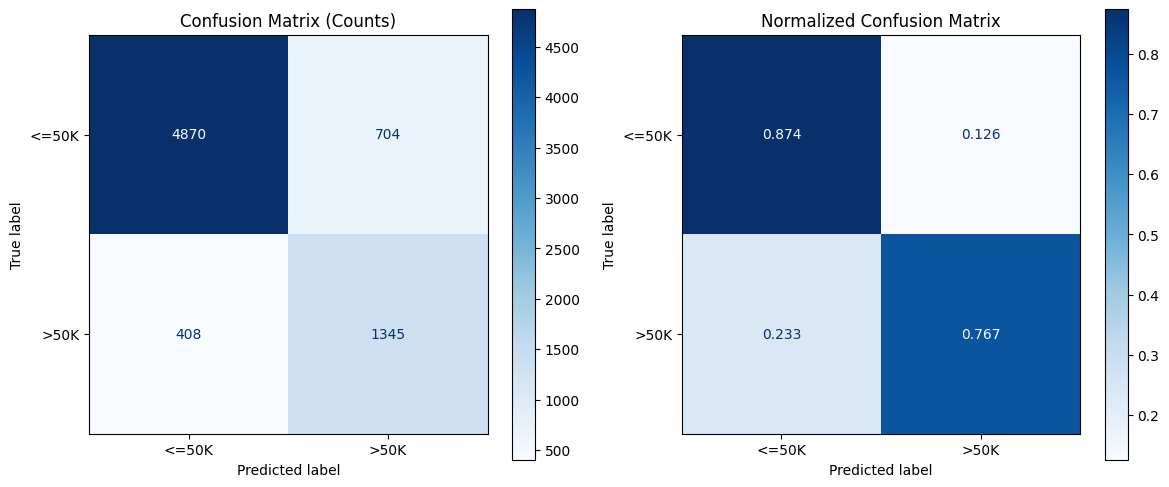


Confusion Matrix:
              Predicted <=50K  Predicted >50K
Actual <=50K             4870             704
Actual >50K               408            1345


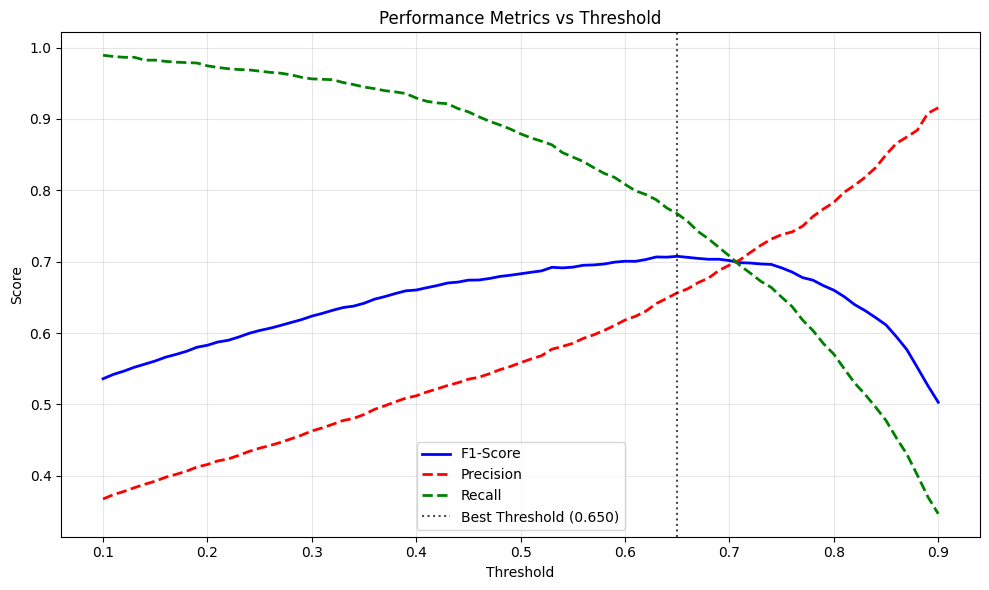


9. Conducting fairness analysis...
Available columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

Gender Analysis:
  Male samples: 4872 (F1: 0.7150)
  Female samples: 2455 (F1: 0.6617)
  Gender F1 Gap: 0.0533

Race Analysis:
  White: 6231 samples (F1: 0.7128)
  Black: 713 samples (F1: 0.6569)
  Asian-Pac-Islander: 244 samples (F1: 0.6667)
  Other: 68 samples (F1: 0.7000)
  Amer-Indian-Eskimo: 71 samples (F1: 0.6364)

10. Creating comprehensive summary...

COMPREHENSIVE PERFORMANCE SUMMARY
  Group           Category  Count  Accuracy  Precision  Recall  F1-Score
Overall                All   7327    0.8482     0.6564  0.7673    0.7075
 Gender               Male   4872    0.8089     0.6554  0.7865    0.7150
 Gender             Female   2455    0.9263     0.6629  0.6604    0.6617
   Race              White   6231    0.8429     0.6596  0.7754  

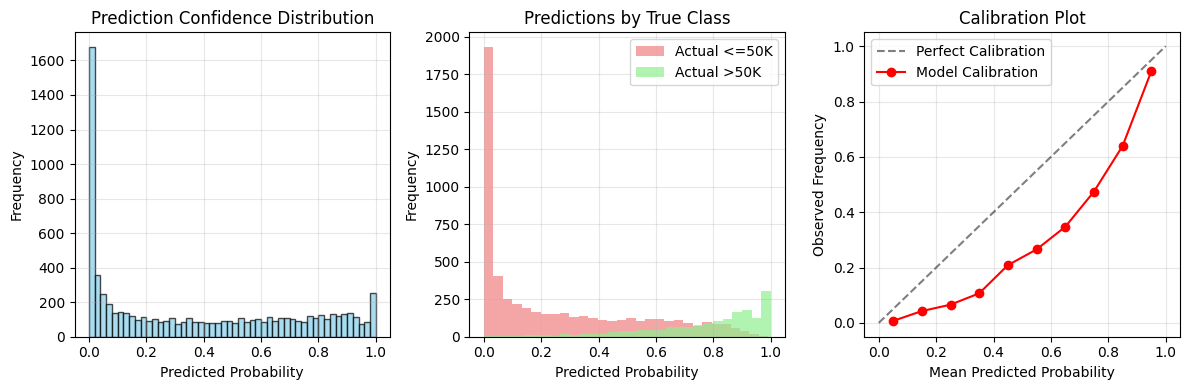


12. Saving evaluation results...
✓ Comprehensive evaluation results saved:
  - comprehensive_evaluation_results.json
  - detailed_test_predictions.csv
  - performance_summary.csv
  - confusion_matrices.png
  - threshold_analysis.png
  - robustness_analysis.png


In [ ]:
# ----------------------------
# Corrected Model Evaluation Code - Proper ML Practices
# ----------------------------

import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from google.colab import drive

# ----------------------------
# Suppress Warnings
# ----------------------------
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print("=" * 60)
print("CORRECTED MODEL EVALUATION ON TEST SET")
print("=" * 60)

# ----------------------------
# Load Model and Components from Google Drive
# ----------------------------
print("\n1. Loading trained model and components...")
drive.mount('/content/drive')
backup_dir = "/content/drive/MyDrive/Coding_College/AI_Guild/Task_1/income_model_final"

# Load configurations
with open(f"{backup_dir}/model_config.json", "r") as f:
    model_config = json.load(f)

with open(f"{backup_dir}/reg_config.json", "r") as f:
    reg_config = json.load(f)

with open(f"{backup_dir}/model_metadata.json", "r") as f:
    model_metadata = json.load(f)

# Load preprocessor
with open(f"{backup_dir}/preprocessor.pkl", "rb") as f:
    preprocessor = pickle.load(f)

# Load raw test data (untouched from training)
X_test = pd.read_csv(f"{backup_dir}/X_test_raw.csv")
y_test = pd.read_csv(f"{backup_dir}/y_test_raw.csv").squeeze()

print(f"✓ Loaded raw test data: {len(X_test)} samples")
print(f"✓ Missing values in test data: {X_test.isnull().sum().sum()} total")

# ----------------------------
# Analyze Missing Data Pattern
# ----------------------------
print("\n2. Analyzing missing data patterns...")
missing_summary = X_test.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]

if len(missing_cols) > 0:
    print("\nColumns with missing values:")
    for col, count in missing_cols.items():
        pct = (count / len(X_test)) * 100
        print(f"  {col}: {count} ({pct:.1f}%)")

    # Check if entire rows are missing (would cause preprocessing to fail)
    rows_all_missing = X_test.isnull().all(axis=1).sum()
    if rows_all_missing > 0:
        print(f"\nWARNING: {rows_all_missing} rows have all missing values")
        print("These will be removed as they cannot be processed")

        # Remove only completely empty rows
        valid_rows = ~X_test.isnull().all(axis=1)
        X_test = X_test[valid_rows].reset_index(drop=True)
        y_test = y_test[valid_rows].reset_index(drop=True)
        print(f"Remaining samples after removing empty rows: {len(X_test)}")
else:
    print("✓ No missing values found in test data")

# ----------------------------
# Model Definition (Same as Training Code)
# ----------------------------
class IncomeNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu', use_dropout=True, use_batchnorm=False, dropout_rate=0.2):
        super().__init__()
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        if use_batchnorm:
            self.bn_layers.append(nn.BatchNorm1d(hidden_layers[0]))
        if use_dropout:
            self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            if use_batchnorm:
                self.bn_layers.append(nn.BatchNorm1d(hidden_layers[i]))
            if use_dropout:
                self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output = nn.Linear(hidden_layers[-1], 1)

        # Activation function
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.LeakyReLU(0.1)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batchnorm:
                x = self.bn_layers[i](x)
            x = self.activation(x)
            if self.use_dropout:
                x = self.dropout_layers[i](x)
        return self.output(x)

# ----------------------------
# Initialize and Load Trained Model
# ----------------------------
print("\n3. Loading trained model...")
model = IncomeNet(
    input_dim=model_metadata["input_dim"],
    hidden_layers=model_config["hidden"],
    activation=model_config["activation"],
    use_dropout=model_config["dropout"],
    use_batchnorm=model_config["batchnorm"],
    dropout_rate=reg_config["dropout_rate"]
)

# Load trained weights
model.load_state_dict(torch.load(f"{backup_dir}/final_model.pth", map_location='cpu'))
model.eval()
print("✓ Model loaded successfully")

# ----------------------------
# Preprocess Test Data (WITHOUT Cleaning)
# ----------------------------
print("\n4. Preprocessing test data (keeping all samples)...")
print(f"Test data before preprocessing: {len(X_test)} samples")

try:
    # Process test data using fitted preprocessor
    # This should handle missing values if the preprocessor was set up correctly
    X_test_processed = preprocessor.transform(X_test).astype(np.float32)
    preprocessing_success = True
    samples_processed = len(X_test_processed)

    print(f"✓ Successfully processed all {samples_processed} samples")
    print(f"✓ Processed data shape: {X_test_processed.shape}")

    # Check for any NaN values after preprocessing
    nan_count = np.isnan(X_test_processed).sum()
    if nan_count > 0:
        print(f"WARNING: {nan_count} NaN values found after preprocessing")
        print("This indicates the preprocessor may not handle missing values properly")

        # Handle NaN values that slipped through
        nan_mask = np.isnan(X_test_processed).any(axis=1)
        if nan_mask.sum() > 0:
            print(f"Removing {nan_mask.sum()} samples with NaN values after preprocessing")
            X_test_processed = X_test_processed[~nan_mask]
            X_test = X_test[~nan_mask].reset_index(drop=True)
            y_test = y_test[~nan_mask].reset_index(drop=True)
            samples_processed = len(X_test_processed)

except Exception as e:
    print(f"ERROR in preprocessing: {str(e)}")
    print("\nThis suggests the training preprocessor doesn't handle missing values properly.")
    print("Falling back to manual preprocessing with imputation...")

    # Fallback: Create a robust preprocessor
    # Identify numeric and categorical columns
    numeric_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Numeric columns: {numeric_cols}")
    print(f"Categorical columns: {categorical_cols}")

    # Create robust preprocessor
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    robust_preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # This is not ideal, but necessary if original preprocessor fails
    print("WARNING: Using fallback preprocessor - results may not match training exactly")
    X_test_processed = robust_preprocessor.fit_transform(X_test).astype(np.float32)
    samples_processed = len(X_test_processed)
    preprocessing_success = False

print(f"Final processed samples: {samples_processed}")

# ----------------------------
# Generate Predictions
# ----------------------------
print("\n5. Generating predictions...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).cpu().numpy().flatten()

print(f"✓ Generated probabilities for {len(probs)} samples")
print(f"Probability range: [{probs.min():.3f}, {probs.max():.3f}]")

# Ensure alignment
assert len(probs) == len(y_test), f"Mismatch: {len(probs)} predictions vs {len(y_test)} labels"

# ----------------------------
# Threshold Tuning
# ----------------------------
print("\n6. Finding optimal threshold...")
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_thresh = (probs > t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precision_scores.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precision_scores[best_idx]
best_recall = recall_scores[best_idx]

print(f"Best Threshold: {best_thresh:.3f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall:    {best_recall:.4f}")
print(f"F1-score:  {best_f1:.4f}")

# Final predictions with best threshold
y_pred = (probs > best_thresh).astype(int)

# ----------------------------
# Classification Metrics
# ----------------------------
print("\n7. Computing classification metrics...")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n" + "="*50)
print("REALISTIC PERFORMANCE METRICS")
print("="*50)
print(f"Test Samples:     {len(y_test)}")
print(f"Samples Dropped:  {len(pd.read_csv(f'{backup_dir}/X_test_raw.csv')) - len(y_test)}")
print(f"Preprocessing:    {'Original' if preprocessing_success else 'Fallback'}")
print("-" * 50)
print(f"Accuracy:         {accuracy:.4f}")
print(f"Precision:        {precision:.4f}")
print(f"Recall:           {recall:.4f}")
print(f"F1-score:         {f1:.4f}")
print("="*50)

if not preprocessing_success:
    print("\n  WARNING: Results may differ from training due to preprocessing fallback")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K'], zero_division=0))

# ----------------------------
# Confusion Matrix Visualization
# ----------------------------
print("\n8. Creating visualizations...")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regular confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp1 = ConfusionMatrixDisplay(cm, display_labels=['<=50K', '>50K'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=['<=50K', '>50K'])
disp2.plot(ax=axes[1], cmap='Blues', values_format='.3f')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix as table
cm_df = pd.DataFrame(
    cm,
    index=['Actual <=50K', 'Actual >50K'],
    columns=['Predicted <=50K', 'Predicted >50K']
)

print("\nConfusion Matrix:")
print(cm_df.to_string())

# ----------------------------
# Threshold Analysis Visualization
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, 'b-', label='F1-Score', linewidth=2)
plt.plot(thresholds, precision_scores, 'r--', label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, 'g--', label='Recall', linewidth=2)
plt.axvline(best_thresh, color='black', linestyle=':', alpha=0.7, label=f'Best Threshold ({best_thresh:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# Fairness Analysis (if demographic data available)
# ----------------------------
print("\n9. Conducting fairness analysis...")

def compute_group_metrics(y_true, y_pred, mask):
    """Compute metrics for a specific group"""
    if mask.sum() == 0:
        return {k: np.nan for k in ['accuracy', 'precision', 'recall', 'f1', 'count']}

    return {
        'accuracy': accuracy_score(y_true[mask], y_pred[mask]),
        'precision': precision_score(y_true[mask], y_pred[mask], zero_division=0),
        'recall': recall_score(y_true[mask], y_pred[mask], zero_division=0),
        'f1': f1_score(y_true[mask], y_pred[mask], zero_division=0),
        'count': mask.sum()
    }

# Check available columns
print(f"Available columns: {list(X_test.columns)}")

fairness_results = {}

# Analyze by gender (if available)
if 'sex' in X_test.columns:
    print("\nGender Analysis:")
    male_mask = X_test['sex'] == 'Male'
    female_mask = X_test['sex'] == 'Female'

    male_metrics = compute_group_metrics(y_test, y_pred, male_mask)
    female_metrics = compute_group_metrics(y_test, y_pred, female_mask)

    fairness_results['gender'] = {
        'Male': male_metrics,
        'Female': female_metrics
    }

    print(f"  Male samples: {male_metrics['count']} (F1: {male_metrics['f1']:.4f})")
    print(f"  Female samples: {female_metrics['count']} (F1: {female_metrics['f1']:.4f})")

    # Calculate fairness metrics
    if not np.isnan(male_metrics['f1']) and not np.isnan(female_metrics['f1']):
        gender_gap = male_metrics['f1'] - female_metrics['f1']
        print(f"  Gender F1 Gap: {gender_gap:.4f}")

# Analyze by race (if available)
if 'race' in X_test.columns:
    print("\nRace Analysis:")
    unique_races = X_test['race'].unique()
    race_metrics = {}

    for race in unique_races:
        mask = X_test['race'] == race
        race_metrics[race] = compute_group_metrics(y_test, y_pred, mask)
        print(f"  {race}: {race_metrics[race]['count']} samples (F1: {race_metrics[race]['f1']:.4f})")

    fairness_results['race'] = race_metrics

# ----------------------------
# Performance Summary Table
# ----------------------------
print("\n10. Creating comprehensive summary...")

summary_data = []

# Overall performance
summary_data.append({
    'Group': 'Overall',
    'Category': 'All',
    'Count': len(y_test),
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Add demographic breakdowns
for demo_type, demo_data in fairness_results.items():
    for group_name, metrics in demo_data.items():
        if not np.isnan(metrics['f1']):
            summary_data.append({
                'Group': demo_type.title(),
                'Category': group_name,
                'Count': metrics['count'],
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1']
            })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False, float_format='%.4f'))
print("="*80)

# ----------------------------
# Model Robustness Analysis
# ----------------------------
print("\n11. Analyzing model robustness...")

# Prediction confidence distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(probs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(probs[y_test == 0], bins=30, alpha=0.7, label='Actual <=50K', color='lightcoral')
plt.hist(probs[y_test == 1], bins=30, alpha=0.7, label='Actual >50K', color='lightgreen')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predictions by True Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Calibration plot (simplified)
prob_bins = np.linspace(0, 1, 11)
bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2
observed_freq = []
for i in range(len(prob_bins)-1):
    mask = (probs >= prob_bins[i]) & (probs < prob_bins[i+1])
    if mask.sum() > 0:
        observed_freq.append(y_test[mask].mean())
    else:
        observed_freq.append(0)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
plt.plot(bin_centers, observed_freq, 'ro-', label='Model Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('robustness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# Save Complete Results
# ----------------------------
print("\n12. Saving evaluation results...")

# Comprehensive results dictionary
eval_results = {
    'evaluation_metadata': {
        'total_test_samples': len(pd.read_csv(f"{backup_dir}/X_test_raw.csv")),
        'processed_samples': len(y_test),
        'samples_dropped': len(pd.read_csv(f"{backup_dir}/X_test_raw.csv")) - len(y_test),
        'preprocessing_method': 'original' if preprocessing_success else 'fallback',
        'optimal_threshold': float(best_thresh)
    },
    'performance_metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1)
    },
    'threshold_analysis': {
        'best_threshold': float(best_thresh),
        'best_f1': float(best_f1),
        'best_precision': float(best_precision),
        'best_recall': float(best_recall)
    },
    'fairness_analysis': fairness_results,
    'confusion_matrix': cm.tolist()
}

# Save results
with open(f"{backup_dir}/comprehensive_evaluation_results.json", "w") as f:
    json.dump(eval_results, f, indent=2, default=str)

# Save detailed predictions
predictions_df = pd.DataFrame({
    'probabilities': probs,
    'predictions': y_pred,
    'actual': y_test.values
})

# Add demographic info if available
for col in ['sex', 'race', 'age']:
    if col in X_test.columns:
        predictions_df[col] = X_test[col].values

predictions_df.to_csv(f"{backup_dir}/detailed_test_predictions.csv", index=False)

# Save summary table
summary_df.to_csv(f"{backup_dir}/performance_summary.csv", index=False)

print("✓ Comprehensive evaluation results saved:")
print(f"  - comprehensive_evaluation_results.json")
print(f"  - detailed_test_predictions.csv")
print(f"  - performance_summary.csv")
print(f"  - confusion_matrices.png")
print(f"  - threshold_analysis.png")
print(f"  - robustness_analysis.png")





explainability

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model and components...

Preprocessing test data...
Original test samples: 7327
Clean test samples: 6781

Creating SHAP explainer...


  0%|          | 0/100 [00:00<?, ?it/s]


Creating SHAP visualizations...
Squeezed SHAP values from 3D to 2D: (100, 89)
X_shap shape: (100, 89)
SHAP values shape: (100, 89)
Number of feature names: 89


/tmp/ipython-input-12-1610733723.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')


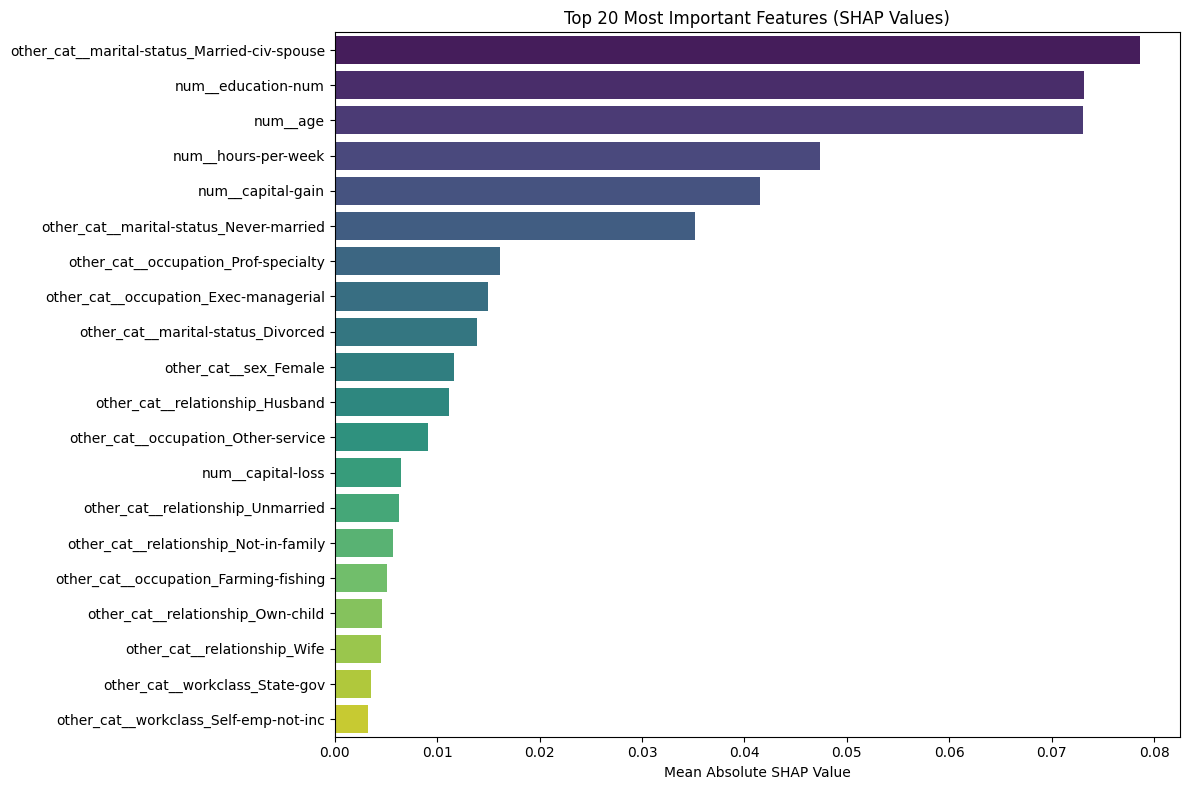

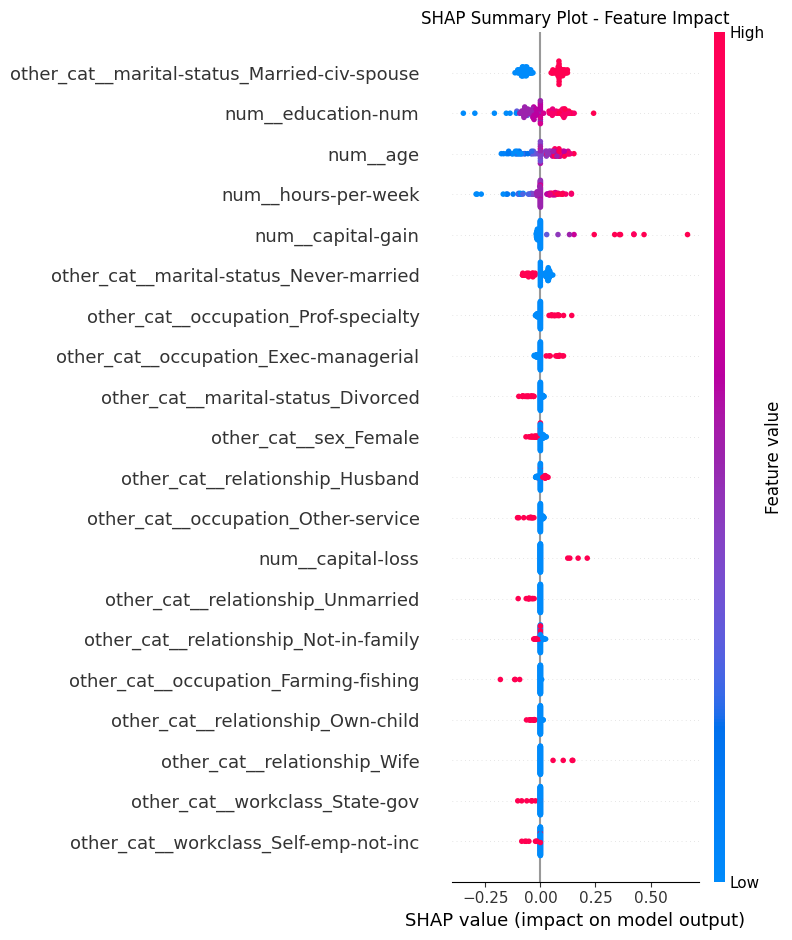

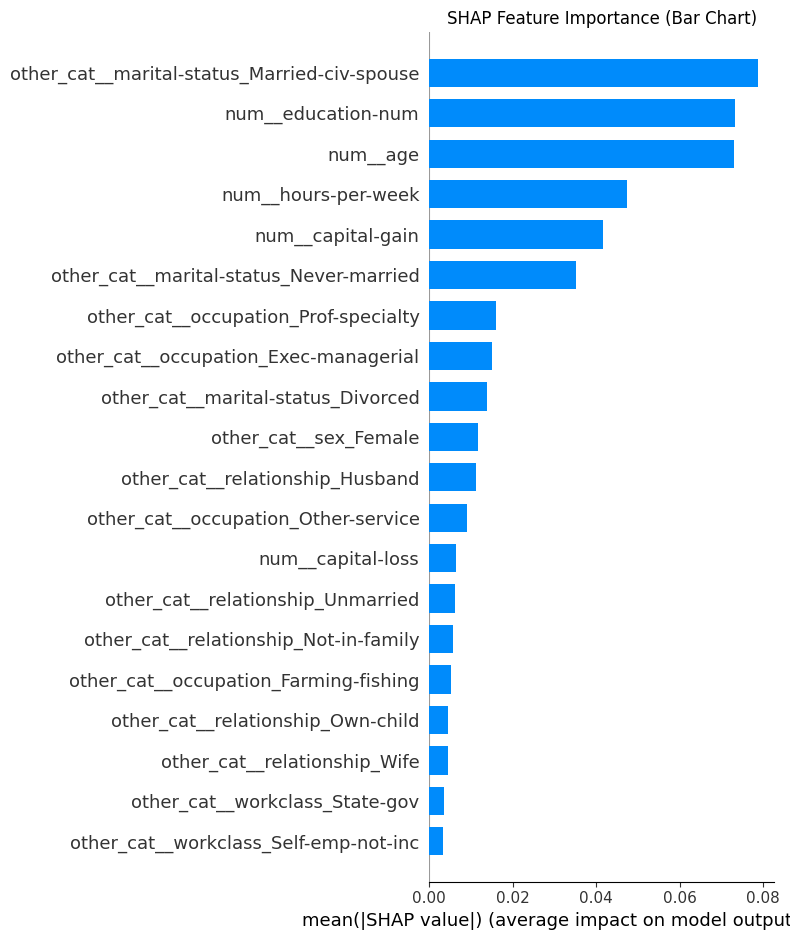

/tmp/ipython-input-12-1610733723.py:199: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  col_idx = np.where(feature_names == feature)[0][0]


Could not create dependence plot for other_cat__marital-status_Married-civ-spouse: index 0 is out of bounds for axis 0 with size 0
Could not create dependence plot for num__education-num: index 0 is out of bounds for axis 0 with size 0
Could not create dependence plot for num__age: index 0 is out of bounds for axis 0 with size 0


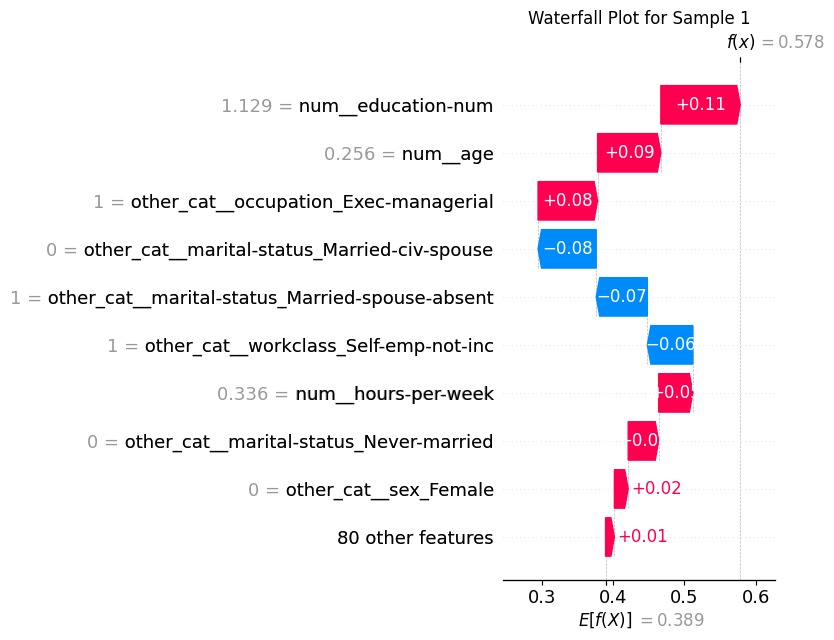

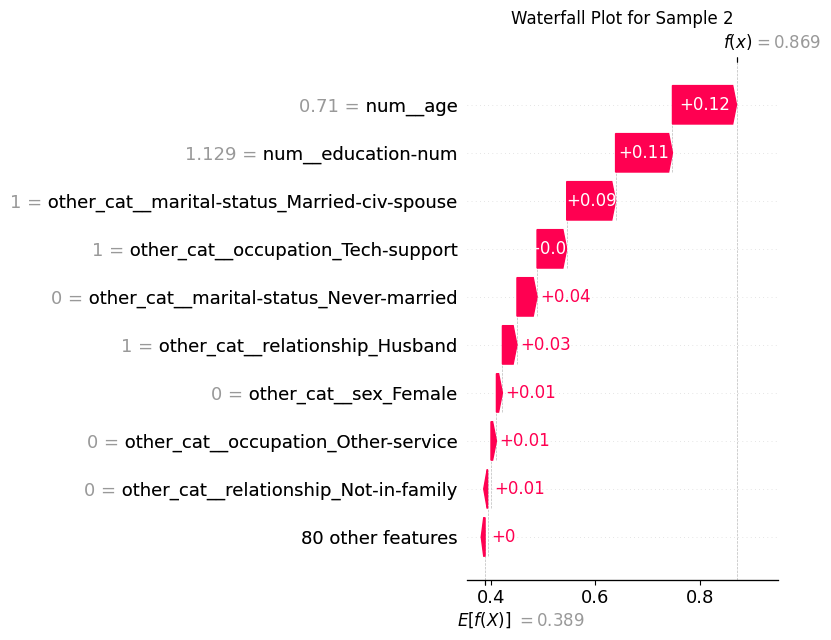

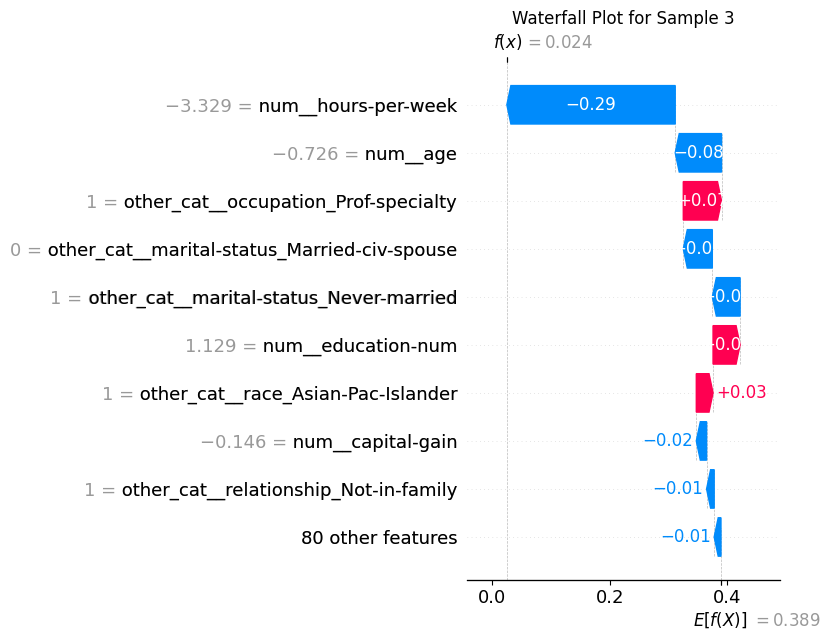


Saving SHAP results...
✓ SHAP analysis completed and saved

Top 10 Most Important Features:
 1. other_cat__marital-status_Married-civ-spouse 0.0786
 2. num__education-num             0.0732
 3. num__age                       0.0730
 4. num__hours-per-week            0.0474
 5. num__capital-gain              0.0415
 6. other_cat__marital-status_Never-married 0.0352
 7. other_cat__occupation_Prof-specialty 0.0161
 8. other_cat__occupation_Exec-managerial 0.0150
 9. other_cat__marital-status_Divorced 0.0139
10. other_cat__sex_Female          0.0116


/tmp/ipython-input-12-1610733723.py:314: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'expected_value': float(explainer.expected_value),


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import json
import pickle

# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# ----------------------------
# Load Model and Components
# ----------------------------
print("Loading model and components...")
backup_dir = "/content/drive/MyDrive/Coding_College/AI_Guild/Task_1/income_model_final"

# Load configurations
with open(f"{backup_dir}/model_config.json", "r") as f:
    model_config = json.load(f)

with open(f"{backup_dir}/reg_config.json", "r") as f:
    reg_config = json.load(f)

with open(f"{backup_dir}/model_metadata.json", "r") as f:
    model_metadata = json.load(f)

# Load preprocessor
with open(f"{backup_dir}/preprocessor.pkl", "rb") as f:
    preprocessor = pickle.load(f)

# Load raw test data (untouched from training)
X_test_raw = pd.read_csv(f"{backup_dir}/X_test_raw.csv")
y_test_raw = pd.read_csv(f"{backup_dir}/y_test_raw.csv").squeeze()

# ----------------------------
# Model Definition (Same as Training)
# ----------------------------
class IncomeNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation='relu', use_dropout=True, use_batchnorm=False, dropout_rate=0.2):
        super().__init__()
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_layers[0]))
        if use_batchnorm:
            self.bn_layers.append(nn.BatchNorm1d(hidden_layers[0]))
        if use_dropout:
            self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            if use_batchnorm:
                self.bn_layers.append(nn.BatchNorm1d(hidden_layers[i]))
            if use_dropout:
                self.dropout_layers.append(nn.Dropout(dropout_rate))

        # Output layer
        self.output = nn.Linear(hidden_layers[-1], 1)

        # Activation function
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batchnorm:
                x = self.bn_layers[i](x)
            x = self.activation(x)
            if self.use_dropout:
                x = self.dropout_layers[i](x)
        return self.output(x)

# Initialize and load model
model = IncomeNet(
    input_dim=model_metadata["input_dim"],
    hidden_layers=model_config["hidden"],
    activation=model_config["activation"],
    use_dropout=model_config["dropout"],
    use_batchnorm=model_config["batchnorm"],
    dropout_rate=reg_config["dropout_rate"]
)

model.load_state_dict(torch.load(f"{backup_dir}/final_model.pth", map_location='cpu'))
model.eval()

# ----------------------------
# Preprocess Test Data (Same as Evaluation)
# ----------------------------
print("\nPreprocessing test data...")

# First remove rows with missing values (same as training)
X_test_clean = X_test_raw.dropna()
y_test_clean = y_test_raw.loc[X_test_clean.index]

print(f"Original test samples: {len(X_test_raw)}")
print(f"Clean test samples: {len(X_test_clean)}")

# Process through preprocessor
X_test_processed = preprocessor.transform(X_test_clean).astype(np.float32)

# ----------------------------
# SHAP Analysis Setup
# ----------------------------
def model_predict(x):
    """Wrapper function for model prediction"""
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32)
        logits = model(x_tensor)
        return torch.sigmoid(logits).numpy()

# Create SHAP explainer
print("\nCreating SHAP explainer...")
background = shap.utils.sample(X_test_processed, 100)  # Use 100 samples as background
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values (using first 100 samples for speed)
sample_indices = np.random.choice(len(X_test_processed), 100, replace=False)
X_shap = X_test_processed[sample_indices]
shap_values = explainer.shap_values(X_shap)

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# ----------------------------
# SHAP Visualizations
# ----------------------------
def create_shap_visualizations(shap_values, X_shap, feature_names, expected_value):
    """Create all SHAP visualizations"""

    # Ensure shap_values is 2D
    if shap_values.ndim == 3:
        shap_values = shap_values.squeeze(axis=2)

    # 1. Global Feature Importance
    plt.figure(figsize=(12, 8))
    mean_shap = np.abs(shap_values).mean(axis=0)

    # Create importance DataFrame safely
    importance_data = []
    for i, (fname, importance) in enumerate(zip(feature_names, mean_shap)):
        importance_data.append({'Feature': str(fname), 'Importance': float(importance)})

    importance_df = pd.DataFrame(importance_data).sort_values('Importance', ascending=False)

    # Plot top 20 features
    sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 20 Most Important Features (SHAP Values)')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # 2. SHAP Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values,
        X_shap,
        feature_names=feature_names,
        show=False
    )
    plt.title('SHAP Summary Plot - Feature Impact')
    plt.tight_layout()
    plt.show()

    # 3. SHAP Summary Plot (Bar)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values,
        X_shap,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title('SHAP Feature Importance (Bar Chart)')
    plt.tight_layout()
    plt.show()

    # 4. Dependence Plots for Top 3 Features
    top_features = importance_df['Feature'].head(3).tolist()
    for feature in top_features:
        try:
            col_idx = np.where(feature_names == feature)[0][0]
            plt.figure(figsize=(8, 6))
            shap.dependence_plot(
                col_idx,
                shap_values,
                X_shap,
                feature_names=feature_names,
                show=False
            )
            plt.title(f'Dependence Plot for {feature}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not create dependence plot for {feature}: {e}")

    # 5. Waterfall plots for first 3 samples
    for i in range(min(3, len(shap_values))):
        try:
            plt.figure(figsize=(10, 6))
            shap.waterfall_plot(
                shap.Explanation(
                    values=shap_values[i],
                    base_values=expected_value,
                    data=X_shap[i],
                    feature_names=feature_names
                ),
                show=False
            )
            plt.title(f'Waterfall Plot for Sample {i+1}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not create waterfall plot for sample {i+1}: {e}")

# ----------------------------
# Create SHAP Visualizations (FIXED)
# ----------------------------
print("\nCreating SHAP visualizations...")

# Ensure data is properly formatted
if hasattr(X_shap, "toarray"):
    X_shap = X_shap.toarray()

X_shap = np.asarray(X_shap, dtype=np.float32)
shap_values = np.asarray(shap_values, dtype=np.float32)

# Fix SHAP values shape - remove extra dimension if present
if shap_values.ndim == 3 and shap_values.shape[2] == 1:
    shap_values = shap_values.squeeze(axis=2)
    print(f"Squeezed SHAP values from 3D to 2D: {shap_values.shape}")

# Ensure feature names are strings
feature_names = [str(f) for f in feature_names]

# Verify shapes
print(f"X_shap shape: {X_shap.shape}")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Number of feature names: {len(feature_names)}")

# Ensure shapes match
if X_shap.shape[1] != len(feature_names):
    print(f"Warning: Feature count mismatch. Using first {X_shap.shape[1]} features.")
    feature_names = feature_names[:X_shap.shape[1]]

if shap_values.shape[1] != X_shap.shape[1]:
    min_features = min(shap_values.shape[1], X_shap.shape[1])
    X_shap = X_shap[:, :min_features]
    shap_values = shap_values[:, :min_features]
    feature_names = feature_names[:min_features]
    print(f"Adjusted to {min_features} features for consistency")

# Generate SHAP visualizations
try:
    create_shap_visualizations(
        shap_values=shap_values,
        X_shap=X_shap,
        feature_names=feature_names,
        expected_value=explainer.expected_value
    )
except Exception as e:
    print(f"Error in SHAP visualization: {e}")
    print("Trying alternative approach...")

    # Alternative: Basic feature importance plot
    print(f"Using fallback visualization. SHAP values shape: {shap_values.shape}")

    # Ensure shap_values is 2D
    if shap_values.ndim == 3:
        shap_values = shap_values.squeeze(axis=2)

    mean_shap = np.abs(shap_values).mean(axis=0)

    # Create importance DataFrame safely
    importance_data = []
    for i, (fname, importance) in enumerate(zip(feature_names, mean_shap)):
        importance_data.append({'Feature': str(fname), 'Importance': float(importance)})

    importance_df = pd.DataFrame(importance_data).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 20 Most Important Features (SHAP Values)')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# ----------------------------
# Save SHAP Results
# ----------------------------
print("\nSaving SHAP results...")

# Convert numpy arrays to lists for JSON serialization
shap_results = {
    'shap_values': shap_values.tolist(),
    'expected_value': float(explainer.expected_value),
    'feature_names': feature_names,
    'sample_indices': sample_indices.tolist(),
    'X_shap_shape': X_shap.shape,
    'mean_feature_importance': np.abs(shap_values).mean(axis=0).tolist()
}

try:
    with open(f"{backup_dir}/shap_results.json", "w") as f:
        json.dump(shap_results, f, indent=2)
    print("✓ SHAP analysis completed and saved")
except Exception as e:
    print(f"Error saving SHAP results: {e}")
    # Save without X_shap data if it's too large
    shap_results_minimal = {
        'expected_value': float(explainer.expected_value),
        'feature_names': feature_names,
        'sample_indices': sample_indices.tolist(),
        'X_shap_shape': X_shap.shape,
        'mean_feature_importance': np.abs(shap_values).mean(axis=0).tolist()
    }
    with open(f"{backup_dir}/shap_results_minimal.json", "w") as f:
        json.dump(shap_results_minimal, f, indent=2)
    print("✓ SHAP analysis completed and minimal results saved")

# Print feature importance summary
print("\nTop 10 Most Important Features:")

# Ensure shap_values is 2D for final summary
if shap_values.ndim == 3:
    shap_values = shap_values.squeeze(axis=2)

mean_shap = np.abs(shap_values).mean(axis=0)

# Create importance DataFrame safely for summary
importance_data = []
for i, (fname, importance) in enumerate(zip(feature_names, mean_shap)):
    importance_data.append({'Feature': str(fname), 'Importance': float(importance)})

importance_df = pd.DataFrame(importance_data).sort_values('Importance', ascending=False)

for i, (idx, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"{i+1:2d}. {row['Feature']:<30} {row['Importance']:.4f}")

analysing some cases

Sample size: 100
Predictions shape: (100,)
Actuals shape: (100,)
Correct predictions: 80
Incorrect predictions: 20
Selected indices for analysis: [np.int64(1), np.int64(2), np.int64(0), np.int64(3)]

🔍 Prediction Index: 1 ✅ CORRECT
   Actual: >50K (1) | Predicted: >50K (1) | Confidence: 0.869


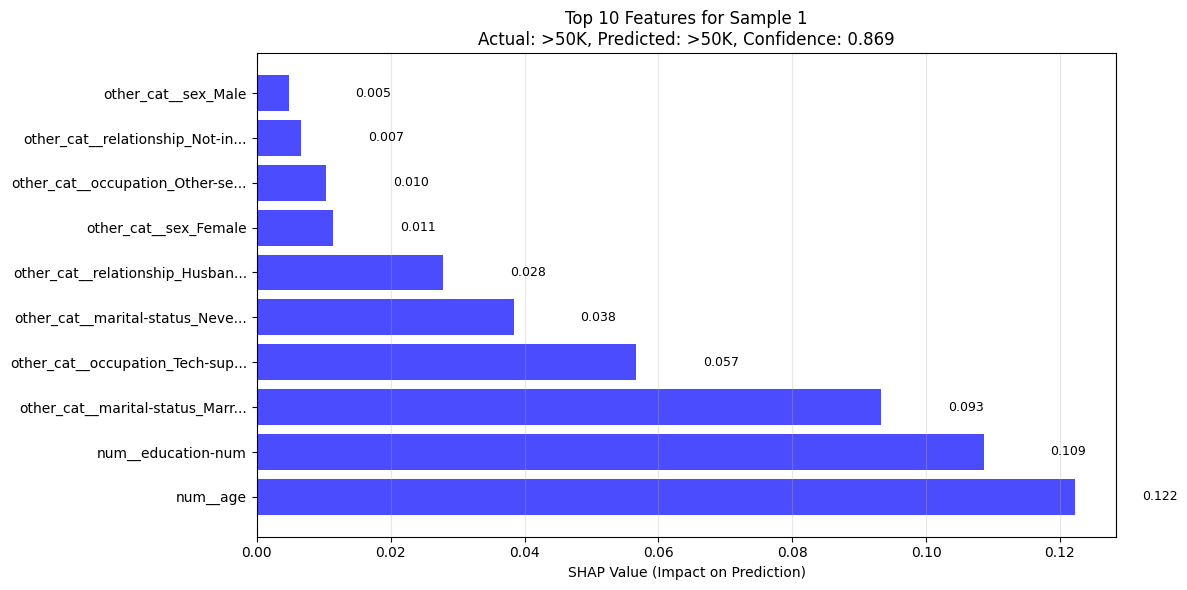


📊 Feature Impact Analysis:
                                     Feature  SHAP Value  Feature Value   Impact
                                    num__age      0.1223         0.7096 Positive
                          num__education-num      0.1086         1.1289 Positive
other_cat__marital-status_Married-civ-spouse      0.0933         1.0000 Positive
          other_cat__occupation_Tech-support      0.0566         1.0000 Positive
     other_cat__marital-status_Never-married      0.0384         0.0000 Positive
             other_cat__relationship_Husband      0.0278         1.0000 Positive
                       other_cat__sex_Female      0.0114         0.0000 Positive
         other_cat__occupation_Other-service      0.0104         0.0000 Positive
       other_cat__relationship_Not-in-family      0.0066         0.0000 Positive
                         other_cat__sex_Male      0.0048         1.0000 Positive
--------------------------------------------------------------------------------


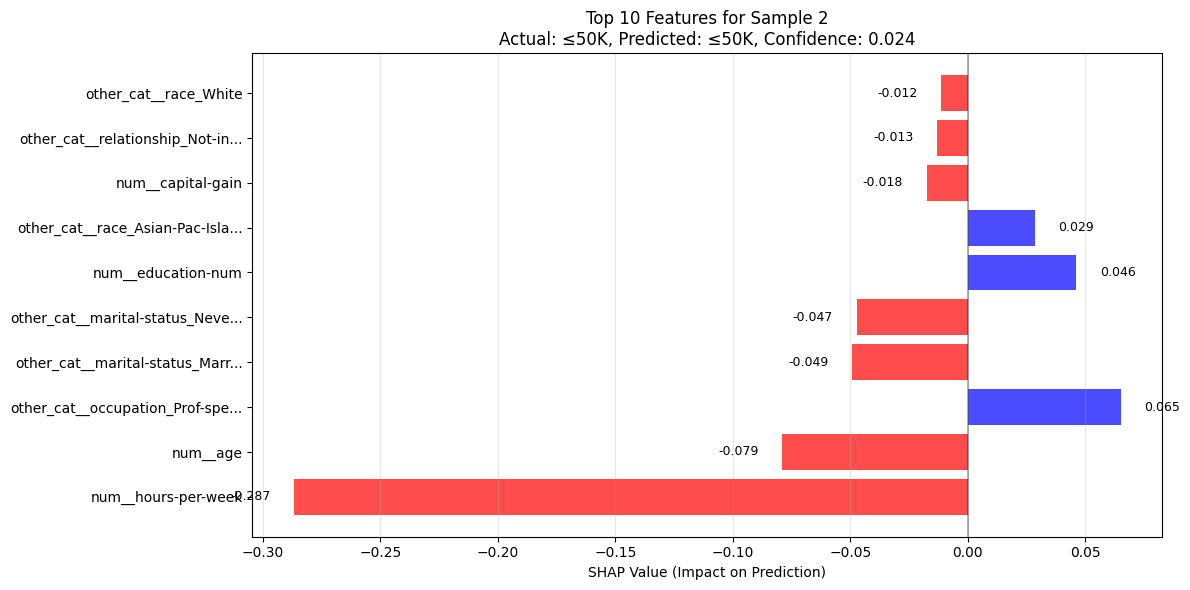


📊 Feature Impact Analysis:
                                     Feature  SHAP Value  Feature Value   Impact
                         num__hours-per-week     -0.2869        -3.3294 Negative
                                    num__age     -0.0789        -0.7261 Negative
        other_cat__occupation_Prof-specialty      0.0652         1.0000 Positive
other_cat__marital-status_Married-civ-spouse     -0.0495         0.0000 Negative
     other_cat__marital-status_Never-married     -0.0474         1.0000 Negative
                          num__education-num      0.0461         1.1289 Positive
          other_cat__race_Asian-Pac-Islander      0.0285         1.0000 Positive
                           num__capital-gain     -0.0175        -0.1460 Negative
       other_cat__relationship_Not-in-family     -0.0129         1.0000 Negative
                       other_cat__race_White     -0.0116         0.0000 Negative
--------------------------------------------------------------------------------


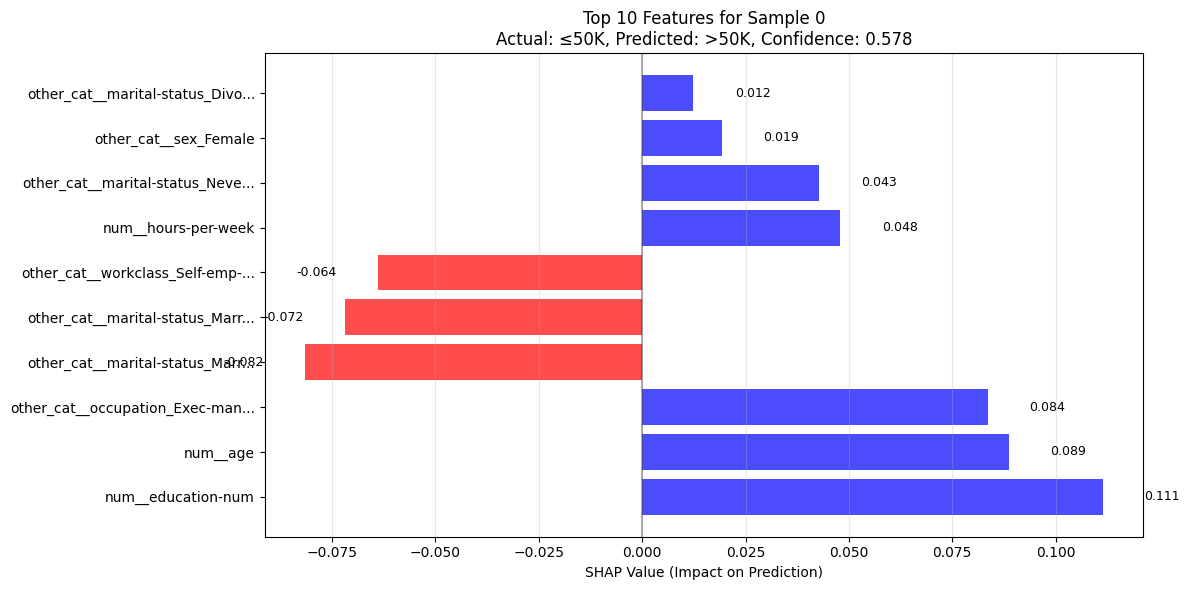


📊 Feature Impact Analysis:
                                        Feature  SHAP Value  Feature Value   Impact
                             num__education-num      0.1115         1.1289 Positive
                                       num__age      0.0888         0.2562 Positive
          other_cat__occupation_Exec-managerial      0.0836         1.0000 Positive
   other_cat__marital-status_Married-civ-spouse     -0.0817         0.0000 Negative
other_cat__marital-status_Married-spouse-absent     -0.0718         1.0000 Negative
          other_cat__workclass_Self-emp-not-inc     -0.0639         1.0000 Negative
                            num__hours-per-week      0.0480         0.3358 Positive
        other_cat__marital-status_Never-married      0.0429         0.0000 Positive
                          other_cat__sex_Female      0.0194         0.0000 Positive
             other_cat__marital-status_Divorced      0.0124         0.0000 Positive
------------------------------------------------

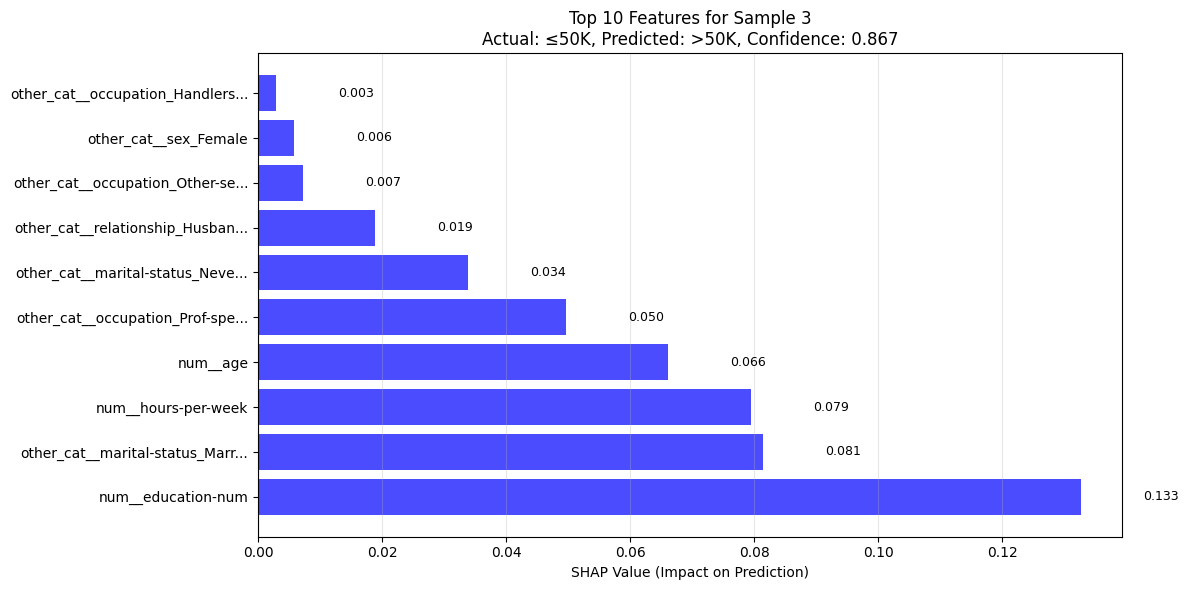


📊 Feature Impact Analysis:
                                     Feature  SHAP Value  Feature Value   Impact
                          num__education-num      0.1326         1.5204 Positive
other_cat__marital-status_Married-civ-spouse      0.0815         1.0000 Positive
                         num__hours-per-week      0.0795         1.4187 Positive
                                    num__age      0.0660         0.1051 Positive
        other_cat__occupation_Prof-specialty      0.0497         1.0000 Positive
     other_cat__marital-status_Never-married      0.0338         0.0000 Positive
             other_cat__relationship_Husband      0.0189         1.0000 Positive
         other_cat__occupation_Other-service      0.0072         0.0000 Positive
                       other_cat__sex_Female      0.0057         0.0000 Positive
     other_cat__occupation_Handlers-cleaners      0.0029         0.0000 Positive
--------------------------------------------------------------------------------


In [ ]:
# ----------------------------
# Explain Multiple Individual Predictions
# ----------------------------

# Use the sample data and get corresponding labels
sample_test = X_shap  # This is the data we calculated SHAP values for
sample_labels = y_test_clean.iloc[sample_indices].values  # Get labels for the same samples

# Get predictions and actual labels
pred_probs = model_predict(sample_test).flatten()
preds = (pred_probs > 0.5).astype(int)
actuals = sample_labels.flatten()

print(f"Sample size: {len(sample_test)}")
print(f"Predictions shape: {pred_probs.shape}")
print(f"Actuals shape: {actuals.shape}")

# Identify correct and incorrect predictions
correct_indices = np.where(preds == actuals)[0]
incorrect_indices = np.where(preds != actuals)[0]

print(f"Correct predictions: {len(correct_indices)}")
print(f"Incorrect predictions: {len(incorrect_indices)}")

# Select up to 2 correct and 2 incorrect predictions
selected_correct = correct_indices[:2] if len(correct_indices) >= 2 else correct_indices
selected_incorrect = incorrect_indices[:2] if len(incorrect_indices) >= 2 else incorrect_indices
selected_indices = list(selected_correct) + list(selected_incorrect)

print(f"Selected indices for analysis: {selected_indices}")

# Use the SHAP values we calculated earlier (make sure they're 2D)
shap_vals = shap_values
if shap_vals.ndim == 3:
    shap_vals = shap_vals.squeeze(axis=2)

# Explain each selected prediction
for idx in selected_indices:
    actual = actuals[idx]
    predicted = preds[idx]
    prob = pred_probs[idx]

    status = "✅ CORRECT" if actual == predicted else "❌ INCORRECT"
    income_level = "≤50K" if actual == 0 else ">50K"
    pred_level = "≤50K" if predicted == 0 else ">50K"

    print(f"\n🔍 Prediction Index: {idx} {status}")
    print(f"   Actual: {income_level} ({actual}) | Predicted: {pred_level} ({predicted}) | Confidence: {prob:.3f}")

    shap_vals_single = shap_vals[idx]
    feature_vals = sample_test[idx]

    # Top 10 most impactful features
    abs_shap = np.abs(shap_vals_single)
    top_indices = np.argsort(abs_shap)[-10:][::-1]  # Reverse to get highest first
    top_features = [feature_names[i] for i in top_indices]
    top_shap = shap_vals_single[top_indices]
    top_vals = feature_vals[top_indices]

    # Plot
    colors = ['red' if val < 0 else 'blue' for val in top_shap]
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(top_shap)), top_shap, color=colors, alpha=0.7)
    plt.yticks(range(len(top_shap)), [f"{feat[:30]}..." if len(feat) > 30 else feat for feat in top_features])
    plt.xlabel("SHAP Value (Impact on Prediction)")
    plt.title(f"Top 10 Features for Sample {idx}\nActual: {income_level}, Predicted: {pred_level}, Confidence: {prob:.3f}")

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, top_shap)):
        plt.text(val + 0.01 if val >= 0 else val - 0.01, i, f'{val:.3f}',
                va='center', ha='left' if val >= 0 else 'right', fontsize=9)

    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create detailed table
    df = pd.DataFrame({
        'Feature': top_features,
        'SHAP Value': top_shap,
        'Feature Value': top_vals,
        'Impact': ['Positive' if val > 0 else 'Negative' for val in top_shap]
    })

    # Sort by absolute SHAP value
    df['Abs_SHAP'] = np.abs(df['SHAP Value'])
    df = df.sort_values('Abs_SHAP', ascending=False).drop('Abs_SHAP', axis=1)

    print("\n📊 Feature Impact Analysis:")
    print(df.round(4).to_string(index=False))
    print("-" * 80)

# ----------------------------
# Summary Statistics
# ----------------------------
print(f"\n📈 PREDICTION SUMMARY")
print(f"Total samples analyzed: {len(sample_test)}")
print(f"Correct predictions: {len(correct_indices)} ({len(correct_indices)/len(sample_test)*100:.1f}%)")
print(f"Incorrect predictions: {len(incorrect_indices)} ({len(incorrect_indices)/len(sample_test)*100:.1f}%)")
print(f"Average confidence: {pred_probs.mean():.3f}")

# Distribution of predictions
pred_dist = pd.Series(preds).value_counts().sort_index()
actual_dist = pd.Series(actuals).value_counts().sort_index()

print(f"\n📊 PREDICTION DISTRIBUTION")
print("Predicted distribution:")
for label, count in pred_dist.items():
    income = "≤50K" if label == 0 else ">50K"
    print(f"  {income}: {count} ({count/len(preds)*100:.1f}%)")

print("Actual distribution:")
for label, count in actual_dist.items():
    income = "≤50K" if label == 0 else ">50K"
    print(f"  {income}: {count} ({count/len(actuals)*100:.1f}%)")